# QF623 Portfolio Management
## Industry Portfolio
#### Industry Daily data 1st retrieved on `22th Apr 2024`
#### source website: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
#### missing data marked as `-99.99` or `-999.`
#### All calculations based on `Value Weighted Return` but NOT `Equity Weighted Return`

#### strategy evaluating period from `2010-01-01` to `2020-01-01`
#### strategy testing period from `2020-01-01` to `2024-04-18`


In [1]:
## only run this when necessary
# !pip install pandas-datareader
# !pip install yfinance
# !pip install seaborn
# !pip install --upgrade pandas
# !pip install statsmodels
# !pip install ta


In [2]:
import numpy as np # for numerical computing
import pandas as pd # for tabular data manipulation
import matplotlib.pyplot as plt # for data graphics
import matplotlib.dates as mdates
import matplotlib as mpl

import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.formula.api as smf
import pandas_datareader.data as web 
from pandas_datareader import data as pdr
%matplotlib inline
import statsmodels.api as sm
from scipy import stats
from ta.trend import IchimokuIndicator
import yfinance as yf
(
    yf
    .pdr_override()
)
import warnings
# To ignore all warnings
warnings.filterwarnings("ignore")
import os
from scipy.interpolate import interp1d
import seaborn as sns
import os

from scipy.stats import norm
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize
from IPython.display import display
from IPython.display import Image

## <a id = "top">Table of Content</a>
### [0. Preprocessing data](#p0)
* 5 Industry Portfolios - clean
* 10 Industry Portfolios - clean
* 12 Industry Portfolios - clean
* 17 Industry Portfolios - clean
* 30 Industry Portfolios - clean

* 38 Industry Portfolios - missing 76860
* 48 Industry Portfolios - missing 56262
* 49 Industry Portfolios - missing 67186

### [1. Strategy Evaluation](#p1)
- ##### [1.1 Strategy Weightage](#p11)
- ##### [1.2 Holding History](#p12)
- ##### [1.3 In-Sample Performance](#p13)
- ##### [1.4 Value-at-Risk (1d in percentage) ](#p14)
- ##### [1.5 Consolidated Metrics ](#p15)
- ##### [1.6 Out-of-Sample Performance ](#p16)


### [2. Strategy Tuning](#p2)
- ##### [2.1 Efficiency Frontier](#p21)
- ##### [2.2 Rolling Window](#p22)
- ##### [2.3 Diversity Effect](#p23)
- ##### [2.4 Shorting Effect](#p24)
- ##### [2.5 Risk Management](#p25)
- ##### [2.6 Model Decisions](#p26)


## <a id = "p0"> 0. </a> Preprocessing Data [back to table of contents](#top)
#### missing data marked as `-99.99` or `-999.`
#### clean data chop from `2007-01-01`
#### strategy evaluating period from `2010-01-01` to `2020-01-01`
#### strategy testing period from `2020-01-01` to `2024-02-29`


In [3]:
def Ind_read(file, skip=9, ind_col=0, keep_duplicate='first'):
    df =\
        pd.read_csv(file,
                    skiprows=skip,
                    index_col=ind_col)        
    df.index =\
        df.index.astype(str)
    
    df =\
        df\
        [~df.index.duplicated(keep=keep_duplicate)]\
        [:-3]
    df =\
        df.astype(float)
    df.index =\
        pd.to_datetime(df.index)
    print("Missing data Counts: ", (df < -99).sum().sum())
    print(df.shape)
    return df

In [4]:
Ind38 = Ind_read('38_Industry_Portfolios_Daily.csv')
Ind48 = Ind_read('48_Industry_Portfolios_Daily.csv')
Ind49 = Ind_read('49_Industry_Portfolios_Daily.csv')

Missing data Counts:  76860
(25690, 38)
Missing data Counts:  56262
(25690, 48)
Missing data Counts:  67186
(25690, 49)


In [5]:
Ind5 = Ind_read('5_Industry_Portfolios_Daily.csv')
Ind10 = Ind_read('10_Industry_Portfolios_Daily.csv')
Ind12 = Ind_read('12_Industry_Portfolios_Daily.csv')
Ind17 = Ind_read('17_Industry_Portfolios_Daily.csv')
Ind30 = Ind_read('30_Industry_Portfolios_Daily.csv')

Missing data Counts:  0
(25690, 5)
Missing data Counts:  0
(25690, 10)
Missing data Counts:  0
(25690, 12)
Missing data Counts:  0
(25690, 17)
Missing data Counts:  0
(25690, 30)


Only good data shall be used, say the 5 to 30 portfolios daily data is suitable

In [6]:
Ind10

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
1926-07-01,0.02,-0.28,-0.23,0.57,-0.21,-0.02,-0.01,0.97,0.61,0.20
1926-07-02,0.29,1.07,0.81,0.64,0.36,0.26,0.01,0.13,0.47,0.10
1926-07-06,0.24,0.72,0.22,0.17,0.47,0.17,-0.23,0.23,0.73,-0.18
1926-07-07,0.27,0.06,0.23,-0.04,-0.10,0.32,-0.59,0.33,0.17,0.16
1926-07-08,0.69,0.05,0.15,0.12,0.35,0.40,-0.36,0.91,-0.20,0.39
...,...,...,...,...,...,...,...,...,...,...
2024-02-23,0.28,-1.81,0.37,-0.53,-0.30,0.01,0.52,0.43,0.46,0.31
2024-02-26,-0.46,2.62,-0.06,0.42,-0.40,-0.59,0.20,-0.22,-1.67,-0.41
2024-02-27,-0.02,0.43,0.22,-0.46,0.28,0.73,0.21,0.29,1.72,0.28
2024-02-28,-0.03,0.97,0.20,-0.40,-0.58,0.00,0.12,-0.57,0.33,-0.03


In [7]:
Ind5.tail()

,Cnsmr,Manuf,HiTec,Hlth,Other
2024-02-23,0.18,0.16,-0.29,0.43,0.31
2024-02-26,0.35,-0.23,-0.41,-0.22,-0.41
2024-02-27,0.19,0.32,0.31,0.29,0.28
2024-02-28,0.20,0.07,-0.55,-0.57,-0.03
2024-02-29,0.56,0.40,1.02,-0.90,0.42


In [8]:
Ind17.tail()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
2024-02-23,0.24,0.10,-0.55,0.54,0.69,0.42,0.49,0.79,1.35,0.45,-0.23,-1.46,0.26,0.46,0.39,0.20,-0.05
2024-02-26,-0.41,-0.81,0.38,-0.26,-0.46,-0.57,-0.33,-0.07,0.86,-0.13,0.48,2.46,-0.43,-1.67,0.21,-0.21,-0.68
2024-02-27,-0.11,0.63,-0.47,0.55,0.44,0.23,-0.15,0.97,1.17,0.28,-0.06,0.81,0.10,1.72,-0.12,0.26,0.49
2024-02-28,-0.08,-1.55,-0.32,-0.39,-0.11,-0.20,-0.18,0.48,-0.57,1.92,-0.58,1.04,-0.01,0.33,-0.02,-0.09,-0.38
2024-02-29,0.63,1.91,0.42,0.19,0.24,1.27,-0.68,1.05,0.82,0.54,1.67,0.05,0.45,0.33,0.74,0.21,0.45


In [9]:
Ind30.tail()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2024-02-23,0.07,0.64,0.45,0.03,-0.09,0.36,0.54,0.43,0.49,0.54,...,0.01,-0.04,-0.53,0.47,0.19,1.10,0.42,0.50,0.20,0.52
2024-02-26,-0.38,-0.64,-1.16,-0.40,-0.08,-0.54,-0.26,-0.22,-0.50,-0.28,...,-0.59,-0.74,0.05,-0.71,-0.57,0.52,0.19,-0.40,-0.21,-1.20
2024-02-27,-0.25,0.11,-0.02,1.75,0.60,0.05,0.49,0.29,0.41,2.19,...,0.73,0.33,0.19,0.47,0.10,0.22,0.34,-0.25,0.26,-0.08
2024-02-28,0.12,-0.50,0.27,-0.18,-0.46,0.41,-0.41,-0.57,-0.04,0.28,...,0.00,-0.45,-0.67,-0.13,-0.43,0.22,0.08,0.30,-0.09,0.70
2024-02-29,0.87,0.09,-0.39,1.36,1.57,-0.36,0.12,-0.90,1.11,1.83,...,0.56,1.01,1.07,1.05,0.93,0.09,0.79,0.50,0.21,-0.26


In [10]:
Ind30.loc['20240226':'20240229']

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2024-02-26,-0.38,-0.64,-1.16,-0.40,-0.08,-0.54,-0.26,-0.22,-0.50,-0.28,...,-0.59,-0.74,0.05,-0.71,-0.57,0.52,0.19,-0.40,-0.21,-1.20
2024-02-27,-0.25,0.11,-0.02,1.75,0.60,0.05,0.49,0.29,0.41,2.19,...,0.73,0.33,0.19,0.47,0.10,0.22,0.34,-0.25,0.26,-0.08
2024-02-28,0.12,-0.50,0.27,-0.18,-0.46,0.41,-0.41,-0.57,-0.04,0.28,...,0.00,-0.45,-0.67,-0.13,-0.43,0.22,0.08,0.30,-0.09,0.70
2024-02-29,0.87,0.09,-0.39,1.36,1.57,-0.36,0.12,-0.90,1.11,1.83,...,0.56,1.01,1.07,1.05,0.93,0.09,0.79,0.50,0.21,-0.26


## <a id = "p1"> 1. </a> Strategy Evaluating [back to table of contents](#top)

In [11]:
train_start = '20100101'
train_end = '20200101'
final_test = '20240301'

##### <a id = "p11"> </a> 1.1 Strategy Weightage [back to table of contents](#top)

In [12]:
def Eff_Front(Ind_daily, start, end, bounds = Bounds(0,1)):
    
    '''
    Using `minimize` function for solution solving

    * function: calculate annualized risk from normal daily return
    * initial guess: equal weight (or other guess vector)
    * method: `trust-constr`
    * linear_constraint
    * bounds

    -> solve for result

    '''
    Ind_ret =\
        Ind_daily.loc[start:end]
    if end in Ind_ret:
        Ind_ret = Ind_ret[:-1]
    # convert the percentage value back to decimal
    Ind_ret = Ind_ret / 100
    
    r = np.mean(Ind_ret,axis=0)*252     
    cov = Ind_ret.cov()
    port_stderr = lambda w:np.sqrt(np.dot(w,np.dot(w,cov))*252)
    invSharpe = lambda w:np.sqrt(np.dot(w,np.dot(w,cov))*252)/(r@w)    
    w = np.ones(Ind_ret.shape[1])
    x0 = w/np.sum(w) 
    
    linear_constraint =\
        LinearConstraint(np.ones((Ind_ret.shape[1],),dtype=int),1,1)    
    
#     bounds = Bounds(0,1)    
    
    result_min =\
        minimize(port_stderr,
                 x0,
                 method="trust-constr",
                 constraints=linear_constraint,
                 bounds=bounds)    
    w_min = result_min.x

    Return_min = r@w_min
    Risk_min = port_stderr(w_min)
    
    result_max =\
        minimize(invSharpe,
                 x0,
                 method="trust-constr",
                 constraints=linear_constraint,
                 bounds=bounds)  
    
    w_max = result_max.x 
    Return_max = r@w_max
    Risk_max = port_stderr(w_max)    
    
    return [w_min, Return_min, Risk_min],[w_max, Return_max, Risk_max]

In [13]:
Eff10_min, Eff10_max =\
   Eff_Front(Ind10, train_start, train_end, Bounds(0,1)) 

print("weightage by min risk portfolio is: ", Eff10_min[0])
print("Sum of total weightages: ", Eff10_min[0].sum())
print("expected annualize min risk portfolio return is: ", Eff10_min[1])
print("expected annualize min risk portfolio volatility is: ", Eff10_min[2])

weightage by min risk portfolio is:  [5.02979637e-01 2.33760202e-06 3.96893183e-06 3.03554087e-06
 1.16695545e-07 1.90356242e-02 9.17833724e-02 6.06984309e-02
 3.25490386e-01 3.09039587e-06]
Sum of total weightages:  1.0000000000000089
expected annualize min risk portfolio return is:  0.12519556146948474
expected annualize min risk portfolio volatility is:  0.11799572359772272


In [14]:
Eff10_max[0]

array([8.78448292e-02, 1.12464441e-07, 3.55152140e-07, 5.41474866e-08,
       1.79747223e-06, 1.20509740e-01, 4.90988850e-01, 1.15402088e-01,
       1.85251827e-01, 3.47118987e-07])

##### <a id = "p12"> </a> 1.2 Holding History [back to table of contents](#top)

In [15]:
def w_construct(idx, cols, w_list):
    w_df =\
        pd.DataFrame(index = idx,
                     columns = cols)
    w_df.iloc[:] = w_list
    w_df['Sum_w'] = w_df.sum(axis=1)
    return w_df

In [16]:
# construct holding weight indexed by date tags
idx =\
    Ind10.loc[train_start:train_end].index
if train_end in idx:
    idx = idx[:-1]
Eff10_min_w =\
    w_construct(idx, Ind10.columns, Eff10_min[0])
Eff10_max_w =\
    w_construct(idx, Ind10.columns, Eff10_max[0])
Eff10_min_w

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Sum_w
2010-01-04,0.50298,0.000002,0.000004,0.000003,0.0,0.019036,0.091783,0.060698,0.32549,0.000003,1.0
2010-01-05,0.50298,0.000002,0.000004,0.000003,0.0,0.019036,0.091783,0.060698,0.32549,0.000003,1.0
2010-01-06,0.50298,0.000002,0.000004,0.000003,0.0,0.019036,0.091783,0.060698,0.32549,0.000003,1.0
2010-01-07,0.50298,0.000002,0.000004,0.000003,0.0,0.019036,0.091783,0.060698,0.32549,0.000003,1.0
2010-01-08,0.50298,0.000002,0.000004,0.000003,0.0,0.019036,0.091783,0.060698,0.32549,0.000003,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.50298,0.000002,0.000004,0.000003,0.0,0.019036,0.091783,0.060698,0.32549,0.000003,1.0
2019-12-26,0.50298,0.000002,0.000004,0.000003,0.0,0.019036,0.091783,0.060698,0.32549,0.000003,1.0
2019-12-27,0.50298,0.000002,0.000004,0.000003,0.0,0.019036,0.091783,0.060698,0.32549,0.000003,1.0
2019-12-30,0.50298,0.000002,0.000004,0.000003,0.0,0.019036,0.091783,0.060698,0.32549,0.000003,1.0


##### <a id = "p13"> </a> 1.3 In-Sample Performance [back to table of contents](#top)

In [17]:
def Daily_ret(Ind_daily, w_df):
    # convert the percentage value back to decimal
    Ind_ret = Ind_daily / 100
    Day_ret =\
        pd.DataFrame(index = w_df.index, 
                     columns = w_df.columns[:-1])

    for idx in w_df.index:
        Day_ret.loc[idx] =\
            Ind_ret.loc[idx] * w_df.loc[idx]
    Day_ret['ret'] = Day_ret.sum(axis = 1)
    Day_ret['PnL'] =\
        (1 + Day_ret['ret']).cumprod()

    return Day_ret

In [18]:
# Establish the In-Sample daily performance
Eff10_min_ret =\
    Daily_ret(Ind10, Eff10_min_w)
Eff10_max_ret =\
    Daily_ret(Ind10, Eff10_max_w)
Eff10_min_ret

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,ret,PnL
2010-01-04,0.004929,0.0,0.0,0.0,0.0,0.00028,0.000734,0.000795,0.002148,0.0,0.008887,1.008887
2010-01-05,0.001559,0.0,0.0,0.0,0.0,0.000021,-0.000119,-0.000364,-0.002734,0.0,-0.001637,1.007235
2010-01-06,0.001107,0.0,0.0,0.0,-0.0,-0.000196,-0.000037,0.000322,0.001758,0.0,0.002953,1.010210
2010-01-07,0.000201,0.0,0.0,-0.0,-0.0,-0.000032,0.000569,0.000079,-0.001465,0.0,-0.000648,1.009555
2010-01-08,-0.002414,0.0,0.0,0.0,0.0,-0.000029,0.0,0.000152,-0.000163,0.0,-0.002454,1.007078
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.000402,0.0,-0.0,0.0,-0.0,0.000034,0.000184,0.000042,0.000033,0.0,-0.000110,3.239319
2019-12-26,0.000956,0.0,0.0,0.0,0.0,0.000084,0.001193,-0.000146,0.000553,0.0,0.002640,3.247872
2019-12-27,0.00166,-0.0,0.0,-0.0,-0.0,0.000013,-0.000018,-0.000146,0.000488,-0.0,0.001997,3.254359
2019-12-30,-0.002012,-0.0,-0.0,-0.0,-0.0,-0.000089,-0.000514,-0.000449,-0.000098,-0.0,-0.003162,3.244068


##### <a id = "p14"> </a> 1.4 Value-at-Risk [back to table of contents](#top)

In [19]:
def VaR_para(daily_ret, var=0.01):
    m = daily_ret['ret'].mean()
    std = daily_ret['ret'].std()
    
    VaR1d =\
        (m + std * norm.ppf(var))
    
    if VaR1d > 0:
        VaR1d = 0    
    return abs(VaR1d)

def VaR_hist(daily_ret, var=0.01):
    SR =\
        daily_ret\
        .sort_values(by='ret')\
        .reset_index(drop=True)['ret']
    idx =\
        var *\
        len(SR) - 1
    lower = int(idx)
    upper = lower + 1
        
    VaR1d =\
        SR[lower] +\
        (SR[upper] - SR[lower]) *\
        (idx - lower) * 1
    if VaR1d > 0:
        VaR1d = 0    
    return abs(VaR1d)

In [20]:
# Analysis on 1-day Value-at-Risk metrics
VaR_result =\
    {'Min Risk 1d-VaR':
         [VaR_para(Eff10_min_ret, 0.01),
          VaR_hist(Eff10_min_ret, 0.01),
          VaR_para(Eff10_min_ret, 0.05),
          VaR_hist(Eff10_min_ret, 0.05)],
     'Max Return 1d-VaR':
         [VaR_para(Eff10_max_ret, 0.01),
          VaR_hist(Eff10_max_ret, 0.01),
          VaR_para(Eff10_max_ret, 0.05),
          VaR_hist(Eff10_max_ret, 0.05)],
    }

VaR_result = pd.DataFrame(VaR_result)
VaR_result.index =\
    ['Parametric 1%',
     'Historical 1%',
     'Parametric 5%',
     'Historical 5%']
VaR_result

,Min Risk 1d-VaR,Max Return 1d-VaR
Parametric 1%,0.016795,0.017990
Historical 1%,0.020816,0.024458
Parametric 5%,0.011729,0.012552
Historical 5%,0.011673,0.012739


##### <a id = "p15"> </a> 1.5 Consolidated Metrics [back to table of contents](#top)

In [21]:
# Assuming risk_free_rate is the annualized risk-free rate
risk_free_rate = 0  # You can adjust this value as per your source

In [22]:
Eff10_result =\
{
    'Min Risk Port.':
    [
#         Eff10_min[1],
        Eff10_min_ret['PnL'][-1]**(252/len(Eff10_min_ret))-1,
        Eff10_min_ret['PnL'][-1]-1,
#         Eff10_min[2],
        Eff10_min_ret['ret'].std()*252**0.5,
        VaR_para(Eff10_min_ret, 0.01),
        VaR_hist(Eff10_min_ret, 0.01),
        VaR_para(Eff10_min_ret, 0.05),
        VaR_hist(Eff10_min_ret, 0.05),
    ],
    'Max Return Port.':
    [
#         Eff10_max[1],
        Eff10_max_ret['PnL'][-1]**(252/len(Eff10_max_ret))-1,
        Eff10_max_ret['PnL'][-1]-1,
#         Eff10_max[2],
        Eff10_max_ret['ret'].std()*252**0.5,
        VaR_para(Eff10_max_ret, 0.01),
        VaR_hist(Eff10_max_ret, 0.01),
        VaR_para(Eff10_max_ret, 0.05),
        VaR_hist(Eff10_max_ret, 0.05),
    ],
}


Eff10_result =\
    pd.DataFrame(Eff10_result)


Eff10_result.index =\
[
#     'expected Ann. Return',
    'Ann. Return', 
    'Total Return',
#     'expected Ann. Vol.',    
    'Ann. Vol',     
    'VaR 1d 1% - para',
    'VaR 1d 1% - hist',
    'VaR 1d 5% - para',
    'VaR 1d 5% - hist',
]


# Calculate Sharpe Ratios
sharpe_ratio_min = (Eff10_min_ret['PnL'][-1]**(252/len(Eff10_min_ret))-1 - risk_free_rate) / (Eff10_min_ret['ret'].std() * (252**0.5))
sharpe_ratio_max = (Eff10_max_ret['PnL'][-1]**(252/len(Eff10_max_ret))-1 - risk_free_rate) / (Eff10_max_ret['ret'].std() * (252**0.5))

# Add Sharpe Ratios to the DataFrame
Eff10_result.loc['Sharpe Ratio'] = [sharpe_ratio_min, sharpe_ratio_max]


Eff10_result
# below is In-Sample performance

,Min Risk Port.,Max Return Port.
Ann. Return,0.125465,0.145913
Total Return,2.254661,2.895638
Ann. Vol,0.117996,0.126667
VaR 1d 1% - para,0.016795,0.017990
VaR 1d 1% - hist,0.020816,0.024458
VaR 1d 5% - para,0.011729,0.012552
VaR 1d 5% - hist,0.011673,0.012739
Sharpe Ratio,1.063303,1.151945


In [23]:
Eff10_port =\
{
    'Min Risk Port.':
    Eff10_min[0],
    
    'Max Return Port.':
    Eff10_max[0]
}

Eff10_port =\
    pd.DataFrame(Eff10_port) 
Eff10_port.index =\
    Ind10.columns

Eff10_port

,Min Risk Port.,Max Return Port.
NoDur,5.029796e-01,8.784483e-02
Durbl,2.337602e-06,1.124644e-07
Manuf,3.968932e-06,3.551521e-07
Enrgy,3.035541e-06,5.414749e-08
HiTec,1.166955e-07,1.797472e-06
Telcm,1.903562e-02,1.205097e-01
Shops,9.178337e-02,4.909889e-01
Hlth,6.069843e-02,1.154021e-01
Utils,3.254904e-01,1.852518e-01
Other,3.090396e-06,3.471190e-07


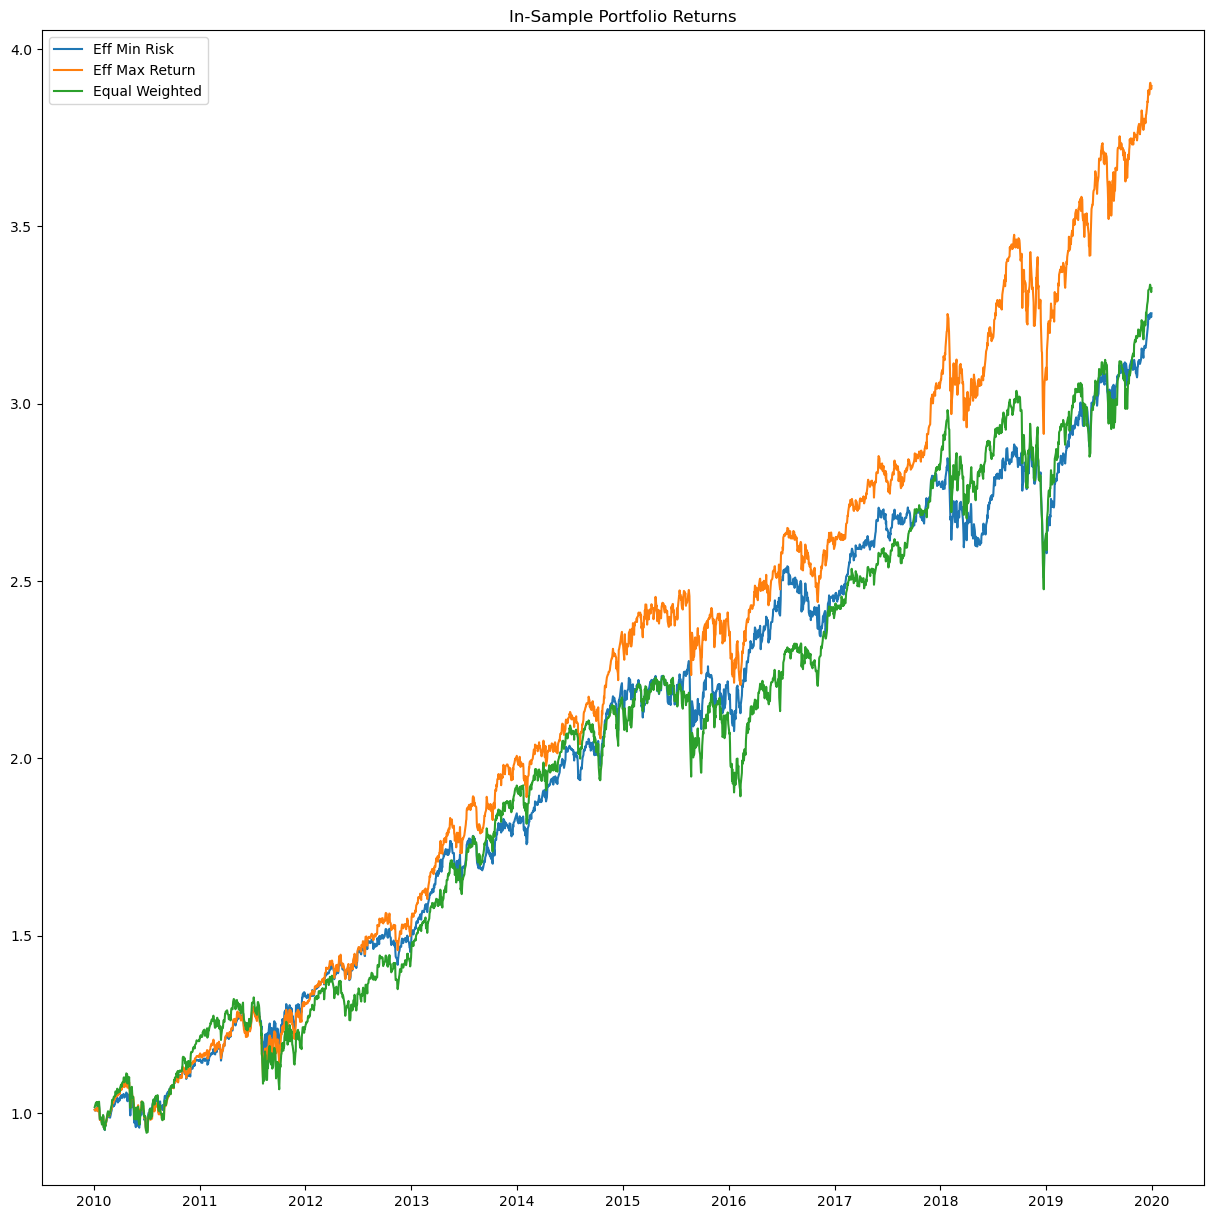

In [24]:
plt.figure(figsize=[15,15])
plt.plot(Eff10_min_ret['PnL'], 
         label = 'Eff Min Risk')
plt.plot(Eff10_max_ret['PnL'], 
         label = 'Eff Max Return')
plt.plot((1+Ind10.loc[train_start:train_end].mean(axis = 1)/100).cumprod(), 
         label = 'Equal Weighted')
plt.title("In-Sample Portfolio Returns")
plt.legend()
plt.show()

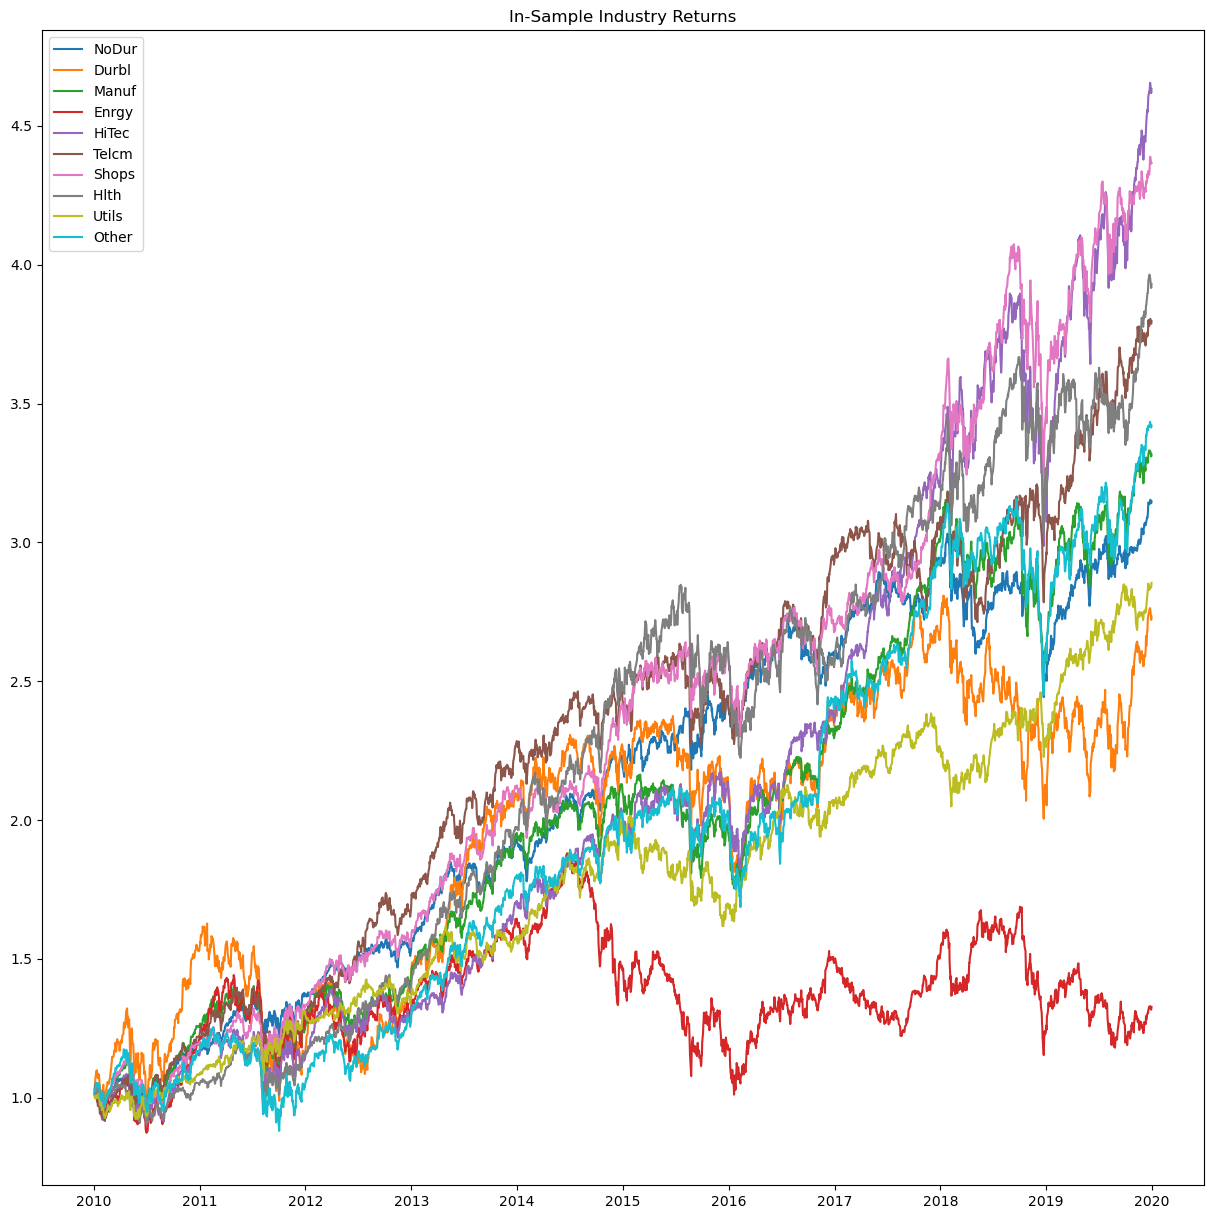

In [25]:
plt.figure(figsize=[15,15])
for col in Ind10.columns:
    Ind_PnL =\
        (1 + Ind10.loc[train_start:train_end,col]/100).cumprod()
    plt.plot(Ind_PnL, label = col)
plt.title("In-Sample Industry Returns")
plt.legend()
plt.show()

##### <a id = "p16"> </a> 1.6 Out-Of-Sample Performance [back to table of contents](#top)

In [26]:
def perform(Ind_daily, w_df, risk_free_rate=0):
    
    # Calculate daily returns
    ret = Daily_ret(Ind_daily, w_df)
    
    # Calculate annualized return and annualized volatility
    annualized_return = ret['PnL'][-1]**(252 / len(ret)) - 1
    annualized_volatility = ret['ret'].std() * (252**0.5)
    
    # Calculate Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    # Prepare the performance metrics
    metrics = {
        'Performance': [
            annualized_return,
            ret['PnL'][-1] - 1,        
            annualized_volatility,                    
            VaR_hist(ret, 0.01),
            VaR_hist(ret, 0.05),
            sharpe_ratio  # Include Sharpe Ratio here
        ]
    }
    
    # Convert metrics to DataFrame
    metrics = pd.DataFrame(metrics)
    metrics.index = [
        'Ann. Return', 
        'Total Return',   
        'Ann. Vol',     
        'VaR 1d 1%',
        'VaR 1d 5%',
        'Sharpe Ratio'  # Add Sharpe Ratio to the index
    ]
    
    return metrics, ret

In [27]:
idx_os =\
    Ind10.loc[train_end:final_test].index
if final_test in idx_os:
    idx_os = idx_os[:-1]
Eff10_min_w_os =\
    w_construct(idx_os, Ind10.columns, Eff10_min[0])
Eff10_max_w_os =\
    w_construct(idx_os, Ind10.columns, Eff10_max[0])
Eff10_max_w_os

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Sum_w
2020-01-02,0.087845,0.0,0.0,0.0,0.000002,0.12051,0.490989,0.115402,0.185252,0.0,1.0
2020-01-03,0.087845,0.0,0.0,0.0,0.000002,0.12051,0.490989,0.115402,0.185252,0.0,1.0
2020-01-06,0.087845,0.0,0.0,0.0,0.000002,0.12051,0.490989,0.115402,0.185252,0.0,1.0
2020-01-07,0.087845,0.0,0.0,0.0,0.000002,0.12051,0.490989,0.115402,0.185252,0.0,1.0
2020-01-08,0.087845,0.0,0.0,0.0,0.000002,0.12051,0.490989,0.115402,0.185252,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-02-23,0.087845,0.0,0.0,0.0,0.000002,0.12051,0.490989,0.115402,0.185252,0.0,1.0
2024-02-26,0.087845,0.0,0.0,0.0,0.000002,0.12051,0.490989,0.115402,0.185252,0.0,1.0
2024-02-27,0.087845,0.0,0.0,0.0,0.000002,0.12051,0.490989,0.115402,0.185252,0.0,1.0
2024-02-28,0.087845,0.0,0.0,0.0,0.000002,0.12051,0.490989,0.115402,0.185252,0.0,1.0


In [28]:
Eff10_min_OS, Eff10_min_OS_ret =\
    perform(Ind10, Eff10_min_w_os)
Eff10_min_OS.columns = ['Min Risk Port - OS']
Eff10_min_OS

,Min Risk Port - OS
Ann. Return,0.057329
Total Return,0.260631
Ann. Vol,0.195790
VaR 1d 1%,0.037433
VaR 1d 5%,0.016529
Sharpe Ratio,0.292810


In [29]:
Eff10_max_OS, Eff10_max_OS_ret =\
    perform(Ind10, Eff10_max_w_os)
Eff10_max_OS.columns = ['Max Return Port - OS']
Eff10_max_OS

,Max Return Port - OS
Ann. Return,0.092859
Total Return,0.446186
Ann. Vol,0.199579
VaR 1d 1%,0.038762
VaR 1d 5%,0.017843
Sharpe Ratio,0.465273


In [30]:
def view_port(pnl_df, name="Returns"):
    plt.figure(figsize=[10,8])
    # Colors and styles
    colors = plt.cm.viridis(np.linspace(0, 1, pnl_df.shape[1]))
    styles = ['-', '--', '-.', ':']

    for i, col in enumerate(pnl_df.columns):
        plt.plot(pnl_df.index, pnl_df[col], label=col, color=colors[i], linestyle=styles[i % len(styles)])

    # Formatting date on x-axis
    if isinstance(pnl_df.index, pd.DatetimeIndex):
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.gcf().autofmt_xdate()  # Auto fits the dates.

    plt.title(name)
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.grid(True)
    plt.legend(title="Symbols", loc='upper left')
    plt.tight_layout()  # Adjusts plot to avoid overlap
    plt.show()
    return

In [31]:

def plot_min_risk_portfolios(rm_min):
    plt.figure(figsize=[10,4])
    # Colors and styles
    colors = ['blue', 'red'] 
    styles = ['-', '--']  # Assuming two lines for two portfolios

    # Plotting the data
    plt.plot(rm_min.index, rm_min['old_PnL'], label='Min Risk Port. w/o Risk Control', color=colors[0], linestyle=styles[0])
    plt.plot(rm_min.index, rm_min['PnL'], label='Min Risk Port. with Risk Control', color=colors[1], linestyle=styles[1])

    # Formatting date on x-axis
    if isinstance(rm_min.index, pd.DatetimeIndex):
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.gcf().autofmt_xdate()  # Auto fits the dates.

    plt.title('Portfolio Risk Control - Min Risk')
    plt.xlabel('Date')
    plt.ylabel('PnL')
    plt.grid(True)
    plt.legend(title="Portfolio Type", loc='upper left')  # Position the legend inside the plot
    plt.tight_layout()  # Adjusts plot to avoid overlap
    plt.show()
    return

In [32]:
def plot_max_return_portfolios(rm_max):
    plt.figure(figsize=[10,4])
    # Custom colors and styles
    colors = ['darkgreen', 'goldenrod']  # Vibrant and contrasting colors
    styles = ['-', '--']  # Different line styles for differentiation

    # Plotting the data
    plt.plot(rm_max.index, rm_max['old_PnL'], label='Max Return Port. w/o Risk Control', color=colors[0], linestyle=styles[0])
    plt.plot(rm_max.index, rm_max['PnL'], label='Max Return Port. with Risk Control', color=colors[1], linestyle=styles[1])

    # Formatting date on x-axis
    if isinstance(rm_max.index, pd.DatetimeIndex):
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.gcf().autofmt_xdate()  # Auto fits the dates.

    plt.title('Portfolio Risk Control - Max Return')
    plt.xlabel('Date')
    plt.ylabel('PnL')
    plt.grid(True)
    plt.legend(title="Portfolio Type", loc='upper left')  # Position the legend inside the plot
    plt.tight_layout()  # Adjusts plot to avoid overlap
    plt.show()

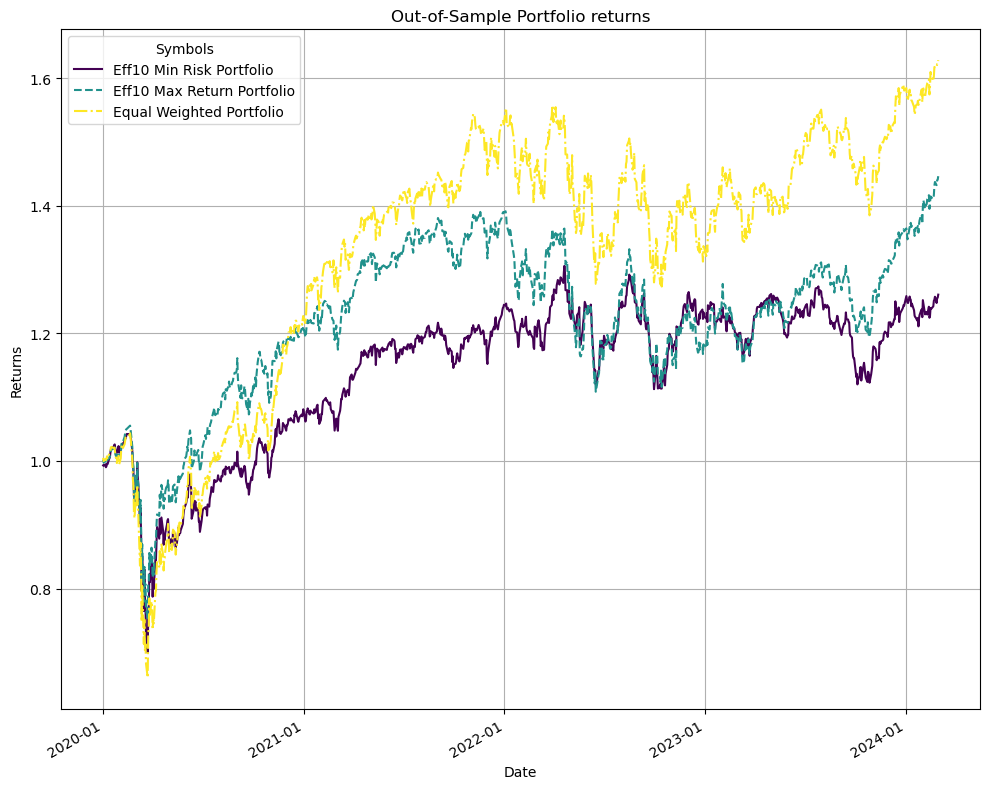

In [33]:
Eff10_port_OS =\
    pd.concat([Eff10_min_OS_ret['PnL'], 
               Eff10_max_OS_ret['PnL'],
              (1+Ind10.loc[train_end:final_test].mean(axis = 1)/100).cumprod()], 
              axis = 1)
Eff10_port_OS.columns =\
    ['Eff10 Min Risk Portfolio',
     'Eff10 Max Return Portfolio', 
     'Equal Weighted Portfolio']
view_port(Eff10_port_OS, 'Out-of-Sample Portfolio returns')

In [34]:
def view_asset(Ind_daily, start, end, name='Returns'):
    plt.figure(figsize=[15,15])
    for col in Ind_daily.columns:
        Ind_PnL =\
            (1 + Ind_daily.loc[start:end,col]/100).cumprod()
        plt.plot(Ind_PnL, label = col)
    plt.title(name)
    plt.legend()
    plt.show()    
    return

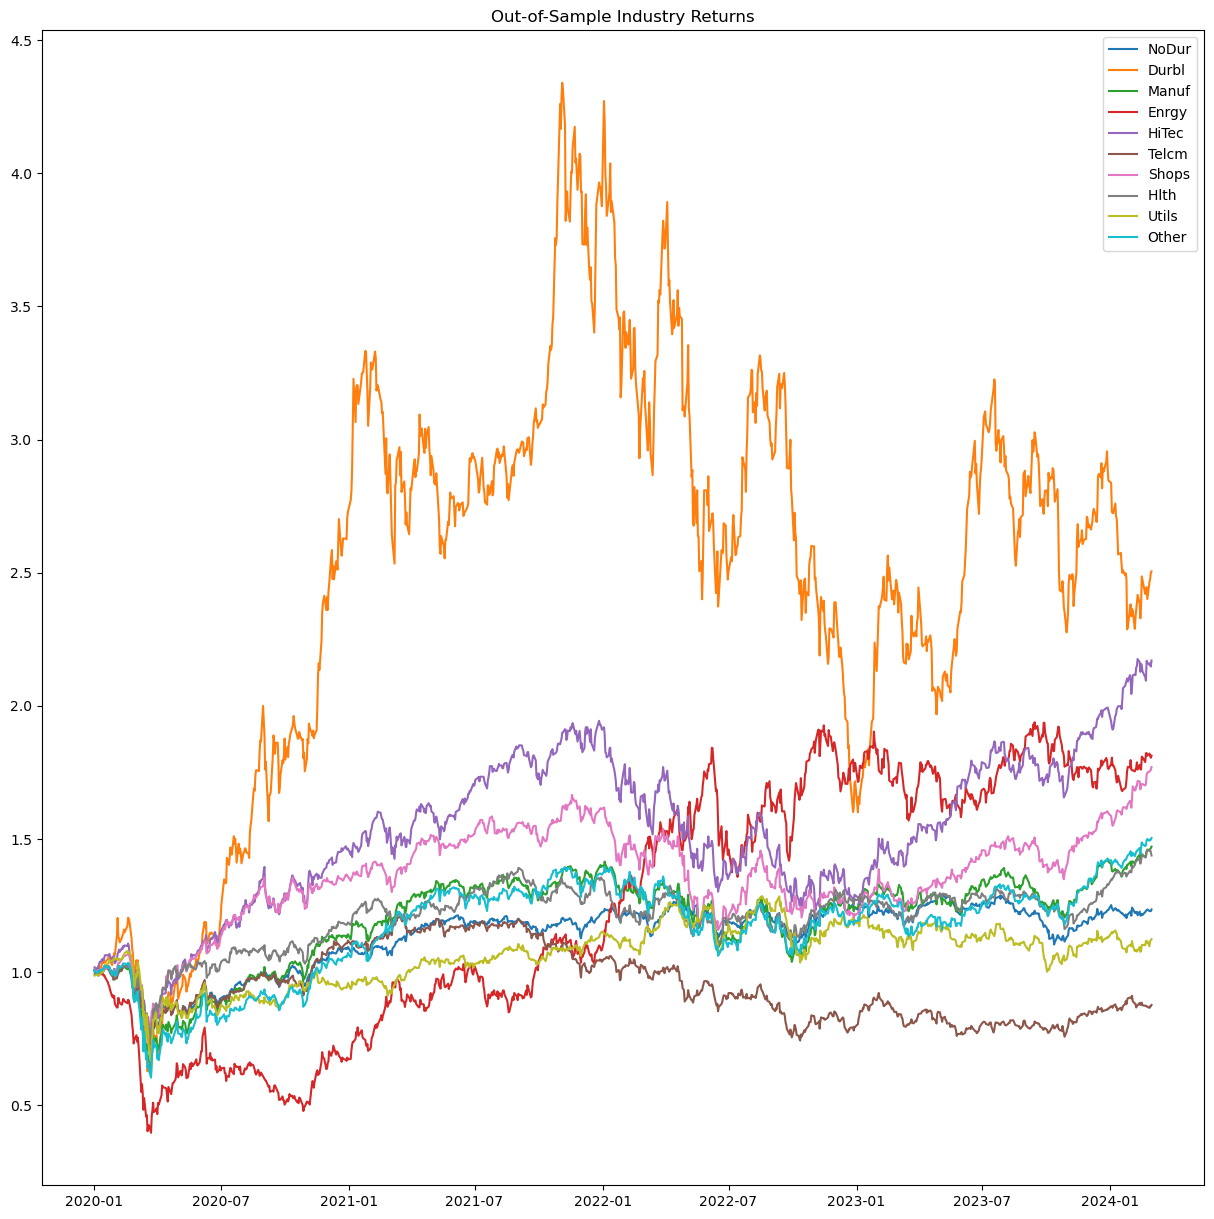

In [35]:
view_asset(Ind10, train_end, final_test, "Out-of-Sample Industry Returns")

## <a id = "p2"> 2. </a> Strategy Tuning [back to table of contents](#top)
* Efficiency frontier
* Rolling window
* Diversity effects
* Shorting effects
* Risk Management
* Model Decision

##### <a id = "p21"> </a> 2.1 Efficiency frontier [back to table of contents](#top)

In [36]:
pre_start = '19900101'

In [37]:
# Generate Weightage
new_Eff10_min, new_Eff10_max =\
   Eff_Front(Ind10, pre_start, train_start, Bounds(0,1)) 

In [38]:
# construct holding weightage indexed by In-Sample date tags
idx =\
    Ind10.loc[train_start:train_end].index
if train_end in idx:
    idx = idx[:-1]
new_Eff10_min_w =\
    w_construct(idx, Ind10.columns, new_Eff10_min[0])
new_Eff10_max_w =\
    w_construct(idx, Ind10.columns, new_Eff10_max[0])

In [39]:
idx


DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', length=2516, freq=None)

In [40]:
# Establish the In-Sample daily performance
new_Eff10_min_ret =\
    Daily_ret(Ind10, new_Eff10_min_w)
new_Eff10_max_ret =\
    Daily_ret(Ind10, new_Eff10_max_w)

In [41]:
# Consolidate In-Sample Performance Metrics
new_Eff10_result =\
{
    'Min Risk Port.':
    [
        new_Eff10_min_ret['PnL'][-1]**(252/len(new_Eff10_min_ret))-1,
        new_Eff10_min_ret['PnL'][-1]-1,
        new_Eff10_min_ret['ret'].std()*252**0.5,
        VaR_para(new_Eff10_min_ret, 0.01),
        VaR_hist(new_Eff10_min_ret, 0.01),
        VaR_para(new_Eff10_min_ret, 0.05),
        VaR_hist(new_Eff10_min_ret, 0.05),
    ],
    'Max Return Port.':
    [
        new_Eff10_max_ret['PnL'][-1]**(252/len(new_Eff10_max_ret))-1,
        new_Eff10_max_ret['PnL'][-1]-1,
        new_Eff10_max_ret['ret'].std()*252**0.5,
        VaR_para(new_Eff10_max_ret, 0.01),
        VaR_hist(new_Eff10_max_ret, 0.01),
        VaR_para(new_Eff10_max_ret, 0.05),
        VaR_hist(new_Eff10_max_ret, 0.05),
    ],
}

# Calculate Sharpe Ratios for both portfolios
sharpe_ratio_min = (new_Eff10_min_ret['PnL'][-1]**(252/len(new_Eff10_min_ret))-1 - risk_free_rate) / (new_Eff10_min_ret['ret'].std() * 252**0.5)
sharpe_ratio_max = (new_Eff10_max_ret['PnL'][-1]**(252/len(new_Eff10_max_ret))-1 - risk_free_rate) / (new_Eff10_max_ret['ret'].std() * 252**0.5)

# Append Sharpe Ratios to the existing metrics dictionary
new_Eff10_result['Min Risk Port.'].append(sharpe_ratio_min)
new_Eff10_result['Max Return Port.'].append(sharpe_ratio_max)

# Convert dictionary into DataFrame
new_Eff10_result = pd.DataFrame(new_Eff10_result)

# Update DataFrame index to include Sharpe Ratio
new_Eff10_result.index = [
    'Ann. Return', 
    'Total Return',
    'Ann. Vol',     
    'VaR 1d 1% - para',
    'VaR 1d 1% - hist',
    'VaR 1d 5% - para',
    'VaR 1d 5% - hist',
    'Sharpe Ratio'  # Add this line to include the Sharpe Ratio
]

# Display the updated DataFrame
print(new_Eff10_result)

new_Eff10_result

                  Min Risk Port.  Max Return Port.
Ann. Return             0.121141          0.115481
Total Return            2.131939          1.977609
Ann. Vol                0.118369          0.126902
VaR 1d 1% - para        0.016865          0.018131
VaR 1d 1% - hist        0.020492          0.023040
VaR 1d 5% - para        0.011783          0.012683
VaR 1d 5% - hist        0.011658          0.012958
Sharpe Ratio            1.023412          0.909997


,Min Risk Port.,Max Return Port.
Ann. Return,0.121141,0.115481
Total Return,2.131939,1.977609
Ann. Vol,0.118369,0.126902
VaR 1d 1% - para,0.016865,0.018131
VaR 1d 1% - hist,0.020492,0.023040
VaR 1d 5% - para,0.011783,0.012683
VaR 1d 5% - hist,0.011658,0.012958
Sharpe Ratio,1.023412,0.909997


In [42]:
Eff10_result

,Min Risk Port.,Max Return Port.
Ann. Return,0.125465,0.145913
Total Return,2.254661,2.895638
Ann. Vol,0.117996,0.126667
VaR 1d 1% - para,0.016795,0.017990
VaR 1d 1% - hist,0.020816,0.024458
VaR 1d 5% - para,0.011729,0.012552
VaR 1d 5% - hist,0.011673,0.012739
Sharpe Ratio,1.063303,1.151945


In [43]:
# construct holding weightage indexed by Out-of-Sample date tags
idx_os =\
    Ind10.loc[train_end:final_test].index
if final_test in idx_os:
    idx_os = idx_os[:-1]
new_Eff10_min_w_os =\
    w_construct(idx_os, Ind10.columns, new_Eff10_min[0])
new_Eff10_max_w_os =\
    w_construct(idx_os, Ind10.columns, new_Eff10_max[0])

In [44]:
new_Eff10_min_OS, new_Eff10_min_OS_ret =\
    perform(Ind10, new_Eff10_min_w_os)
new_Eff10_min_OS.columns = ['Min Risk Port - OS']
new_Eff10_max_OS, new_Eff10_max_OS_ret =\
    perform(Ind10, new_Eff10_max_w_os)
new_Eff10_max_OS.columns = ['Max Return Port - OS']

new_Eff10_result_OS =\
    pd.concat([new_Eff10_min_OS, new_Eff10_max_OS], axis = 1)
new_Eff10_result_OS

,Min Risk Port - OS,Max Return Port - OS
Ann. Return,0.048996,0.088060
Total Return,0.219861,0.419983
Ann. Vol,0.198415,0.202638
VaR 1d 1%,0.038505,0.039456
VaR 1d 5%,0.016840,0.017346
Sharpe Ratio,0.246937,0.434566


In [45]:
Eff10_result_OS =\
    pd.concat([Eff10_min_OS, Eff10_max_OS], axis = 1)
Eff10_result_OS

,Min Risk Port - OS,Max Return Port - OS
Ann. Return,0.057329,0.092859
Total Return,0.260631,0.446186
Ann. Vol,0.195790,0.199579
VaR 1d 1%,0.037433,0.038762
VaR 1d 5%,0.016529,0.017843
Sharpe Ratio,0.292810,0.465273


> ### <span style="color:red;">Including more history does not necessarily improves performance</span>

##### <a id = "p22"> </a> 2.2 Rolling Window [back to table of contents](#top)
* rebalance every N=9 months
* take prior multiple=4 of N as base

In [46]:
today = datetime.datetime.today()
print(today.strftime('%Y%m%d'))
print(today.strftime("%Y-%m-%d"))

today

20240619
2024-06-19


datetime.datetime(2024, 6, 19, 22, 38, 12, 26715)

In [47]:
def gen_date_tag(start_date, end_date, m, multi=2, form='%Y%m%d'):
    date_tags = []
    train_tags = []
    # Convert the input string to a datetime object
    input_date = datetime.datetime.strptime(start_date, form)
    
    while input_date < datetime.datetime.strptime(end_date, form):
        # Format the result date as a string in 'YYYY-MM-DD' format
        date_tags.append(input_date.strftime(form))
        train_date =\
            input_date - relativedelta(months=m*multi)
        train_tags.append(train_date.strftime(form))
        # Move to the next date `m` months later
        input_date += relativedelta(months=m)
    date_tags.append(end_date)
    return date_tags, train_tags

In [48]:
test_date_tag, train_date_tag =\
    gen_date_tag(train_start, train_end, 12, 2)

print(test_date_tag); print(train_date_tag)

['20100101', '20110101', '20120101', '20130101', '20140101', '20150101', '20160101', '20170101', '20180101', '20190101', '20200101']
['20080101', '20090101', '20100101', '20110101', '20120101', '20130101', '20140101', '20150101', '20160101', '20170101']


In [49]:
# def Eff_Front(Ind_daily, start, end, bounds = Bounds(0,1)):

In [50]:
def Roll_Eff(Ind_daily, start, end, 
             m, multi=4, bounds = Bounds(0,1)):
    
    test_tag, train_tag =\
        gen_date_tag(start, end, m, multi)    

    Roll_Min_w =\
        pd.DataFrame(index = Ind_daily.loc[start:end].index, 
                     columns = Ind_daily.columns)
    
    Roll_Max_w =\
        pd.DataFrame(index = Ind_daily.loc[start:end].index, 
                     columns = Ind_daily.columns)
    
    for i in range(len(train_tag)):
        
        temp_min_risk, temp_max_ret =\
           Eff_Front(Ind_daily, train_tag[i], test_tag[i], bounds)
        
        Roll_Min_w.loc[test_tag[i]:test_tag[i+1]] =\
            temp_min_risk[0]
        Roll_Max_w.loc[test_tag[i]:test_tag[i+1]] =\
            temp_max_ret[0]
    if end in Roll_Min_w.index:
        Roll_Min_w = Roll_Min_w[:-1]
    Roll_Min_w['Sum_w'] = Roll_Min_w.sum(axis=1) 
    
    if end in Roll_Max_w.index:
        Roll_Max_w = Roll_Max_w[:-1] 
    Roll_Max_w['Sum_w'] = Roll_Max_w.sum(axis=1)
    
    return Roll_Min_w, Roll_Max_w


In [51]:
def diverse_roll(Ind_daily, start, end, m, multi=4, bounds=Bounds(0, 1), risk_free_rate=0):
 
    Roll_Eff_min_w, Roll_Eff_max_w = Roll_Eff(Ind_daily, start, end, m, multi, bounds)
    
    Roll_Eff_min_ret = Daily_ret(Ind_daily, Roll_Eff_min_w)
    Roll_Eff_max_ret = Daily_ret(Ind_daily, Roll_Eff_max_w)
    
    # Calculate Sharpe Ratios
    sharpe_ratio_min = (Roll_Eff_min_ret['PnL'][-1]**(252/len(Roll_Eff_min_ret))-1 - risk_free_rate) / (Roll_Eff_min_ret['ret'].std() * (252**0.5))
    sharpe_ratio_max = (Roll_Eff_max_ret['PnL'][-1]**(252/len(Roll_Eff_max_ret))-1 - risk_free_rate) / (Roll_Eff_max_ret['ret'].std() * (252**0.5))
    
    # Consolidate In-Sample Performance Metrics
    Roll_Eff_result = {
        'Roll Min Risk Port.': [
            Roll_Eff_min_ret['PnL'][-1]**(252/len(Roll_Eff_min_ret))-1,
            Roll_Eff_min_ret['PnL'][-1]-1,
            Roll_Eff_min_ret['ret'].std()*252**0.5,
            VaR_para(Roll_Eff_min_ret, 0.01),
            VaR_hist(Roll_Eff_min_ret, 0.01),
            VaR_para(Roll_Eff_min_ret, 0.05),
            VaR_hist(Roll_Eff_min_ret, 0.05),
            sharpe_ratio_min
        ],
        'Roll Max Return Port.': [
            Roll_Eff_max_ret['PnL'][-1]**(252/len(Roll_Eff_max_ret))-1,
            Roll_Eff_max_ret['PnL'][-1]-1,
            Roll_Eff_max_ret['ret'].std()*252**0.5,
            VaR_para(Roll_Eff_max_ret, 0.01),
            VaR_hist(Roll_Eff_max_ret, 0.01),
            VaR_para(Roll_Eff_max_ret, 0.05),
            VaR_hist(Roll_Eff_max_ret, 0.05),
            sharpe_ratio_max
        ],
    }

    Roll_Eff_result = pd.DataFrame(Roll_Eff_result)
    Roll_Eff_result.index = [
        'Ann. Return', 
        'Total Return',
        'Ann. Vol',     
        'VaR 1d 1% - para',
        'VaR 1d 1% - hist',
        'VaR 1d 5% - para',
        'VaR 1d 5% - hist',
        'Sharpe Ratio'
    ]

    return [Roll_Eff_result, Roll_Eff_min_ret, Roll_Eff_max_ret]

In [52]:
Roll_Eff10_min_w, Roll_Eff10_max_w =\
    Roll_Eff(Ind10, train_start, train_end, 12, 2, Bounds(0, 1))

In [53]:
# Establish the In-Sample daily performance
Roll_Eff10_min_ret =\
    Daily_ret(Ind10, Roll_Eff10_min_w)
Roll_Eff10_max_ret =\
    Daily_ret(Ind10, Roll_Eff10_max_w)

In [54]:
# Consolidate In-Sample Performance Metrics
Roll_Eff10_result =\
{
    'Roll Min Risk Port.':
    [

        Roll_Eff10_min_ret['PnL'][-1]**(252/len(Roll_Eff10_min_ret))-1,
        Roll_Eff10_min_ret['PnL'][-1]-1,

        Roll_Eff10_min_ret['ret'].std()*252**0.5,
        VaR_para(Roll_Eff10_min_ret, 0.01),
        VaR_hist(Roll_Eff10_min_ret, 0.01),
        VaR_para(Roll_Eff10_min_ret, 0.05),
        VaR_hist(Roll_Eff10_min_ret, 0.05),
    ],
    'Roll Max Return Port.':
    [

        Roll_Eff10_max_ret['PnL'][-1]**(252/len(Roll_Eff10_max_ret))-1,
        Roll_Eff10_max_ret['PnL'][-1]-1,

        Roll_Eff10_max_ret['ret'].std()*252**0.5,
        VaR_para(Roll_Eff10_max_ret, 0.01),
        VaR_hist(Roll_Eff10_max_ret, 0.01),
        VaR_para(Roll_Eff10_max_ret, 0.05),
        VaR_hist(Roll_Eff10_max_ret, 0.05),
    ],
}

# Calculate Sharpe Ratios for both portfolios
sharpe_ratio_min = (Roll_Eff10_min_ret['PnL'][-1]**(252/len(Roll_Eff10_min_ret))-1 - risk_free_rate) / (Roll_Eff10_min_ret['ret'].std()*252**0.5)
sharpe_ratio_max = (Roll_Eff10_max_ret['PnL'][-1]**(252/len(Roll_Eff10_max_ret))-1 - risk_free_rate) / (Roll_Eff10_max_ret['ret'].std()*252**0.5)

# Append Sharpe Ratios to the existing metrics dictionary
Roll_Eff10_result['Roll Min Risk Port.'].append(sharpe_ratio_min)
Roll_Eff10_result['Roll Max Return Port.'].append(sharpe_ratio_max)

# Create the DataFrame
Roll_Eff10_result = pd.DataFrame(Roll_Eff10_result)

# Update the DataFrame index to include Sharpe Ratio
Roll_Eff10_result.index = [
    'Ann. Return', 
    'Total Return',
    'Ann. Vol',     
    'VaR 1d 1% - para',
    'VaR 1d 1% - hist',
    'VaR 1d 5% - para',
    'VaR 1d 5% - hist',
    'Sharpe Ratio'  # Add this line to include the Sharpe Ratio
]

Roll_Eff10_result

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.126803,0.112409
Total Return,2.293485,1.896742
Ann. Vol,0.119180,0.158262
VaR 1d 1% - para,0.016963,0.022720
VaR 1d 1% - hist,0.020883,0.030670
VaR 1d 5% - para,0.011847,0.015926
VaR 1d 5% - hist,0.011813,0.015316
Sharpe Ratio,1.063960,0.710272


In [55]:
roll_selects = {}
window_list = [7, 9, 11, 12]
multi_list = [1, 2, 4, 5]

for window in window_list:
    for multiple in multi_list:
        key = f'w{window}m{multiple}'
        roll_selects[key] =\
            diverse_roll(Ind10, 
                         train_start,
                         train_end,
                         window, 
                         multiple, 
                         Bounds(0,1))


In [56]:
for key, data in roll_selects.items():
    print(key)
    print(data[0])

w7m1
                  Roll Min Risk Port.  Roll Max Return Port.
Ann. Return                  0.130616               0.124364
Total Return                 2.406476               2.223013
Ann. Vol                     0.117106               0.157724
VaR 1d 1% - para             0.016647               0.022599
VaR 1d 1% - hist             0.020014               0.028639
VaR 1d 5% - para             0.011620               0.015828
VaR 1d 5% - hist             0.011405               0.016040
Sharpe Ratio                 1.115367               0.788493
w7m2
                  Roll Min Risk Port.  Roll Max Return Port.
Ann. Return                  0.130070               0.139037
Total Return                 2.390072               2.668421
Ann. Vol                     0.117665               0.156294
VaR 1d 1% - para             0.016731               0.022339
VaR 1d 1% - hist             0.020651               0.029794
VaR 1d 5% - para             0.011679               0.015629
VaR 1d 5% - hi

In [57]:
data

[                  Roll Min Risk Port.  Roll Max Return Port.
 Ann. Return                  0.134890               0.139694
 Total Return                 2.537238               2.689608
 Ann. Vol                     0.120378               0.133182
 VaR 1d 1% - para             0.017110               0.018963
 VaR 1d 1% - hist             0.021108               0.025174
 VaR 1d 5% - para             0.011942               0.013246
 VaR 1d 5% - hist             0.012573               0.013801
 Sharpe Ratio                 1.120550               1.048892,
                NoDur     Durbl     Manuf     Enrgy     HiTec     Telcm  \
 2010-01-04  0.006369  0.000002  0.000003  0.000002  0.000002  0.000002   
 2010-01-05  0.002015  0.000002       0.0  0.000001       0.0       0.0   
 2010-01-06   0.00143  0.000001  0.000001  0.000001 -0.000001 -0.000001   
 2010-01-07   0.00026  0.000001       0.0      -0.0 -0.000001      -0.0   
 2010-01-08 -0.003119       0.0  0.000001       0.0  0.000001     

##### <a id = "p23"> </a> 2.3 Diversity Effect [back to table of contents](#top)

In [58]:
def diverse_roll(Ind_daily, start, end, m, multi=4, bounds=Bounds(0,1), risk_free_rate=0):
    """
    Function to calculate rolling efficiency portfolios and their performance metrics.
    
    Parameters:
        Ind_daily (DataFrame): Daily index data.
        start (int): Start date for rolling period.
        end (int): End date for rolling period.
        m (int): Number of periods for rolling.
        multi (int): Multiplier, potentially used for scaling or adjusting weights.
        bounds (Bounds): Tuple or object indicating the minimum and maximum bounds for portfolio weights.
        risk_free_rate (float): Risk-free rate for calculating the Sharpe Ratio, default is 0.032 or 3.2%.
    
    Returns:
        tuple: Contains the DataFrame of results, and the individual returns data for minimum and maximum risk portfolios.
    """
    # Generate rolling efficient frontier weights
    Roll_Eff_min_w, Roll_Eff_max_w = Roll_Eff(Ind_daily, start, end, m, multi, bounds)
    
    # Calculate returns based on the efficient frontier weights
    Roll_Eff_min_ret = Daily_ret(Ind_daily, Roll_Eff_min_w)
    Roll_Eff_max_ret = Daily_ret(Ind_daily, Roll_Eff_max_w)
    
    # Calculate Sharpe Ratios
    sharpe_ratio_min = (Roll_Eff_min_ret['PnL'][-1]**(252/len(Roll_Eff_min_ret))-1 - risk_free_rate) / (Roll_Eff_min_ret['ret'].std() * (252**0.5))
    sharpe_ratio_max = (Roll_Eff_max_ret['PnL'][-1]**(252/len(Roll_Eff_max_ret))-1 - risk_free_rate) / (Roll_Eff_max_ret['ret'].std() * (252**0.5))

    # Consolidate In-Sample Performance Metrics including Sharpe Ratios
    Roll_Eff_result = {
        'Roll Min Risk Port.': [
            Roll_Eff_min_ret['PnL'][-1]**(252/len(Roll_Eff_min_ret))-1,
            Roll_Eff_min_ret['PnL'][-1]-1,
            Roll_Eff_min_ret['ret'].std()*252**0.5,
            VaR_para(Roll_Eff_min_ret, 0.01),
            VaR_hist(Roll_Eff_min_ret, 0.01),
            VaR_para(Roll_Eff_min_ret, 0.05),
            VaR_hist(Roll_Eff_min_ret, 0.05),
            sharpe_ratio_min
        ],
        'Roll Max Return Port.': [
            Roll_Eff_max_ret['PnL'][-1]**(252/len(Roll_Eff_max_ret))-1,
            Roll_Eff_max_ret['PnL'][-1]-1,
            Roll_Eff_max_ret['ret'].std()*252**0.5,
            VaR_para(Roll_Eff_max_ret, 0.01),
            VaR_hist(Roll_Eff_max_ret, 0.01),
            VaR_para(Roll_Eff_max_ret, 0.05),
            VaR_hist(Roll_Eff_max_ret, 0.05),
            sharpe_ratio_max
        ],
    }

    # Convert results into DataFrame and set the index
    Roll_Eff_result = pd.DataFrame(Roll_Eff_result)
    Roll_Eff_result.index = [
        'Ann. Return', 
        'Total Return',
        'Ann. Vol',     
        'VaR 1d 1% - para',
        'VaR 1d 1% - hist',
        'VaR 1d 5% - para',
        'VaR 1d 5% - hist',
        'Sharpe Ratio'
    ]

    return [Roll_Eff_result, Roll_Eff_min_ret, Roll_Eff_max_ret]

In [59]:
diverse_results = []
diverse_results +=\
    [diverse_roll(Ind5, train_start, train_end, 9, 4, Bounds(0,1))]
diverse_results +=\
    [diverse_roll(Ind10, train_start, train_end, 9, 4, Bounds(0,1))]
diverse_results +=\
    [diverse_roll(Ind12, train_start, train_end, 9, 4, Bounds(0,1))]
diverse_results +=\
    [diverse_roll(Ind17, train_start, train_end, 9, 4, Bounds(0,1))]
diverse_results +=\
    [diverse_roll(Ind30, train_start, train_end, 9, 4, Bounds(0,1))]

In [60]:
# 5 Industry Portfolios
diverse_results[0][0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.137515,0.163363
Total Return,2.619795,3.530107
Ann. Vol,0.132705,0.152660
VaR 1d 1% - para,0.018901,0.021725
VaR 1d 1% - hist,0.025256,0.028890
VaR 1d 5% - para,0.013204,0.015171
VaR 1d 5% - hist,0.013730,0.015667
Sharpe Ratio,1.036248,1.070111


In [61]:
# 10 Industry Portfolios
diverse_results[1][0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.122615,0.141529
Total Return,2.173295,2.749349
Ann. Vol,0.119176,0.142263
VaR 1d 1% - para,0.016977,0.020282
VaR 1d 1% - hist,0.020390,0.026229
VaR 1d 5% - para,0.011861,0.014175
VaR 1d 5% - hist,0.012039,0.014315
Sharpe Ratio,1.028858,0.994838


In [62]:
# 12 Industry Portfolios
diverse_results[2][0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.123234,0.140679
Total Return,2.190805,2.721579
Ann. Vol,0.119148,0.141039
VaR 1d 1% - para,0.016971,0.020107
VaR 1d 1% - hist,0.020390,0.026634
VaR 1d 5% - para,0.011856,0.014052
VaR 1d 5% - hist,0.012039,0.014210
Sharpe Ratio,1.034288,0.997446


In [63]:
# 17 Industry Portfolios
diverse_results[3][0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.129009,0.131435
Total Return,2.358428,2.431184
Ann. Vol,0.114762,0.166362
VaR 1d 1% - para,0.016310,0.023835
VaR 1d 1% - hist,0.020344,0.031224
VaR 1d 5% - para,0.011383,0.016693
VaR 1d 5% - hist,0.011584,0.017173
Sharpe Ratio,1.124144,0.790053


In [64]:
# 30 Industry Portfolios
diverse_results[4][0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.129680,0.112545
Total Return,2.378431,1.900287
Ann. Vol,0.114891,0.146403
VaR 1d 1% - para,0.016327,0.020989
VaR 1d 1% - hist,0.019703,0.026862
VaR 1d 5% - para,0.011394,0.014704
VaR 1d 5% - hist,0.011352,0.014786
Sharpe Ratio,1.128723,0.768732


> ### <span style="color:red;">A more diversed industry portfolio would improve in reducing volitality, by trading-off on returns</span>

##### <a id = "p24"> </a> 2.4 Shorting Effect [back to table of contents](#top)

In [65]:
short_results = []
short_results +=\
    [diverse_roll(Ind10, train_start, train_end, 9, 4, Bounds(0,1))]
short_results +=\
    [diverse_roll(Ind10, train_start, train_end, 9, 4, Bounds(-0.25,1))]
short_results +=\
    [diverse_roll(Ind10, train_start, train_end, 9, 4, Bounds(-0.5,1))]
short_results +=\
    [diverse_roll(Ind10, train_start, train_end, 9, 4, Bounds(-0.75,1))]
short_results +=\
    [diverse_roll(Ind10, train_start, train_end, 9, 4, Bounds(-1,1))]

In [66]:
short_results[0][0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.122615,0.141529
Total Return,2.173295,2.749349
Ann. Vol,0.119176,0.142263
VaR 1d 1% - para,0.016977,0.020282
VaR 1d 1% - hist,0.020390,0.026229
VaR 1d 5% - para,0.011861,0.014175
VaR 1d 5% - hist,0.012039,0.014315
Sharpe Ratio,1.028858,0.994838


In [67]:
short_results[1][0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.143482,0.141219
Total Return,2.813903,2.739207
Ann. Vol,0.111536,0.149473
VaR 1d 1% - para,0.015788,0.021336
VaR 1d 1% - hist,0.019782,0.027351
VaR 1d 5% - para,0.011000,0.014919
VaR 1d 5% - hist,0.010666,0.014506
Sharpe Ratio,1.286423,0.944779


In [68]:
short_results[2][0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.142974,0.148407
Total Return,2.797005,2.981121
Ann. Vol,0.111706,0.165654
VaR 1d 1% - para,0.015815,0.023672
VaR 1d 1% - hist,0.019782,0.030087
VaR 1d 5% - para,0.011019,0.016560
VaR 1d 5% - hist,0.010738,0.016166
Sharpe Ratio,1.279915,0.895889


In [69]:
short_results[3][0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.142974,0.159154
Total Return,2.797005,3.369109
Ann. Vol,0.111706,0.176560
VaR 1d 1% - para,0.015815,0.025226
VaR 1d 1% - hist,0.019782,0.032308
VaR 1d 5% - para,0.011019,0.017646
VaR 1d 5% - hist,0.010738,0.017460
Sharpe Ratio,1.279914,0.901414


In [70]:
short_results[4][0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.142974,0.163027
Total Return,2.797006,3.517071
Ann. Vol,0.111706,0.184302
VaR 1d 1% - para,0.015815,0.026342
VaR 1d 1% - hist,0.019782,0.033327
VaR 1d 5% - para,0.011019,0.018430
VaR 1d 5% - hist,0.010738,0.018078
Sharpe Ratio,1.279915,0.884565


> ### <span style="color:red;">Allowing short position would improve on returns, by trading-off on volitality </span>

##### <a id = "p25"> </a> 2.5 Risk Management [back to table of contents](#top)

In [71]:
rm_target = roll_selects['w9m4']
rm_target[0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.122615,0.141529
Total Return,2.173295,2.749349
Ann. Vol,0.119176,0.142263
VaR 1d 1% - para,0.016977,0.020282
VaR 1d 1% - hist,0.020390,0.026229
VaR 1d 5% - para,0.011861,0.014175
VaR 1d 5% - hist,0.012039,0.014315
Sharpe Ratio,1.028858,0.994838


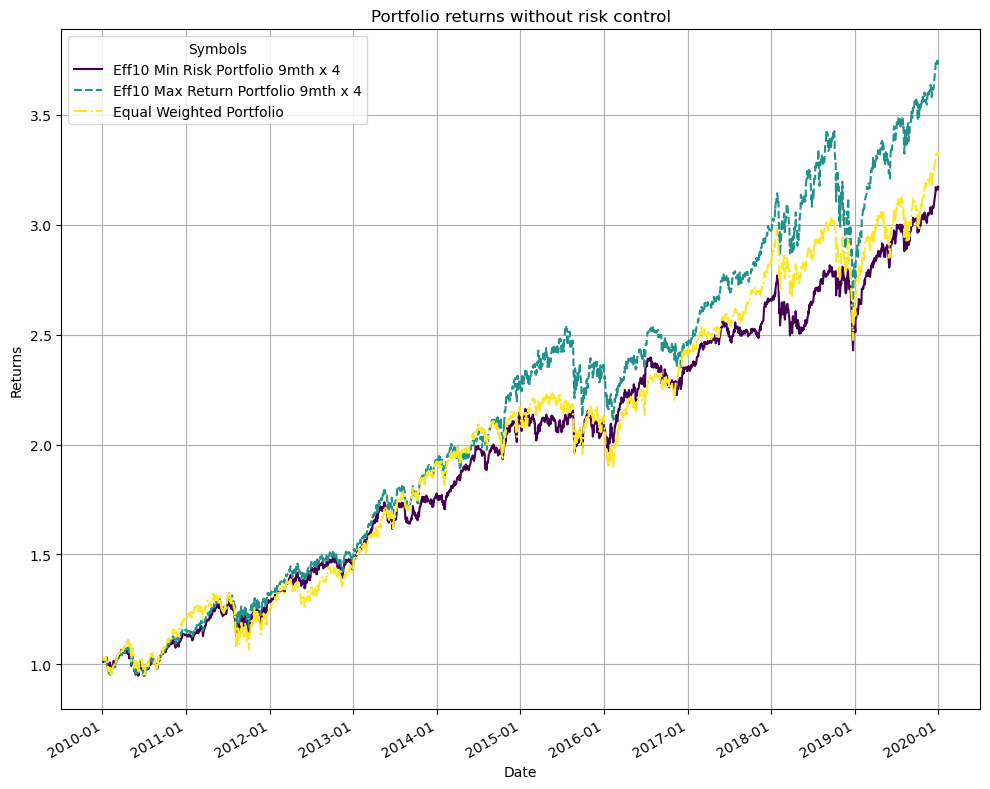

In [72]:
current_port =\
    pd.concat([rm_target[1]['PnL'], 
               rm_target[2]['PnL'],
              (1+Ind10.loc[train_start:train_end].mean(axis = 1)/100).cumprod()], 
              axis = 1)
current_port.columns =\
    ['Eff10 Min Risk Portfolio 9mth x 4',
     'Eff10 Max Return Portfolio 9mth x 4', 
     'Equal Weighted Portfolio']
view_port(current_port, 'Portfolio returns without risk control')

In [73]:
rebalance_test_tag, rebalance_train_tag =\
    gen_date_tag(train_start, train_end, 9, 4)
rebalance_test_tag

['20100101',
 '20101001',
 '20110701',
 '20120401',
 '20130101',
 '20131001',
 '20140701',
 '20150401',
 '20160101',
 '20161001',
 '20170701',
 '20180401',
 '20190101',
 '20191001',
 '20200101']

In [74]:
rm_min_threshold =\
    rm_target[0].loc['VaR 1d 5% - hist','Roll Min Risk Port.']
rm_max_threshold =\
    rm_target[0].loc['VaR 1d 5% - hist','Roll Max Return Port.']
rm_min_threshold, rm_max_threshold

(0.012039448704452263, 0.014314953468917263)

In [75]:
def risk_control(pnl_df, threshold, rebalance_idx, strike=2):
    pnl = pnl_df.copy()
    rebalance_idx = pd.to_datetime(rebalance_idx)
#     pnl.index =\
#         pnl.index.strftime('%Y-%m-%d')
    pnl['pct_change'] =\
        pnl['PnL']\
        .pct_change()
    pnl['pct_change'][0] =\
        pnl['PnL'][0] - 1
    pnl['PnL_rm'] = 0
    pnl['PnL_rm'][0] = pnl['PnL'][0]
    
    risk_management = 0
    current_strike = 0
    for idx in pnl.index:
        if pnl.loc[idx, 'ret'] < -threshold:
            current_strike += 1

            if current_strike >= strike:
                print("2nd strike: ", idx)

                current_strike = 0
                risk_management += 1
                clear_start =\
                    pnl.index[pnl.index.get_loc(idx)+1]
                
                for re_idx in rebalance_idx:
                    clear_end = re_idx
                    if clear_end > clear_start:
                        break
                print(f"risk control No. {risk_management}")
                print(f"from {clear_start} to {clear_end}")
                pnl.loc[clear_start:clear_end, 'pct_change'] = 0
            continue
        current_strike = 0
            
    for i in range(len(pnl)-1):
        pnl.iloc[i+1, -1] =\
            pnl.iloc[i, -1] *\
            (1 + pnl.iloc[i+1, -2])
    
    return pnl

In [76]:
rm_min =\
    risk_control(rm_target[1], rm_min_threshold, rebalance_test_tag, 2)
rm_min =\
    rm_min.rename(columns={'ret': 'old_ret', 
                           'PnL': 'old_PnL',
                           'pct_change': 'ret',
                           'PnL_rm': 'PnL'})
rm_min.tail()

2nd strike:  2011-09-22 00:00:00
risk control No. 1
from 2011-09-23 00:00:00 to 2012-04-01 00:00:00
2nd strike:  2011-10-03 00:00:00
risk control No. 2
from 2011-10-04 00:00:00 to 2012-04-01 00:00:00
2nd strike:  2011-11-01 00:00:00
risk control No. 3
from 2011-11-02 00:00:00 to 2012-04-01 00:00:00
2nd strike:  2013-06-20 00:00:00
risk control No. 4
from 2013-06-21 00:00:00 to 2013-10-01 00:00:00
2nd strike:  2014-07-31 00:00:00
risk control No. 5
from 2014-08-01 00:00:00 to 2015-04-01 00:00:00
2nd strike:  2015-08-21 00:00:00
risk control No. 6
from 2015-08-24 00:00:00 to 2016-01-01 00:00:00
2nd strike:  2015-08-25 00:00:00
risk control No. 7
from 2015-08-26 00:00:00 to 2016-01-01 00:00:00
2nd strike:  2015-12-03 00:00:00
risk control No. 8
from 2015-12-04 00:00:00 to 2016-01-01 00:00:00
2nd strike:  2018-02-05 00:00:00
risk control No. 9
from 2018-02-06 00:00:00 to 2018-04-01 00:00:00
2nd strike:  2018-03-23 00:00:00
risk control No. 10
from 2018-03-26 00:00:00 to 2018-04-01 00:00:00

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,old_ret,old_PnL,ret,PnL
2019-12-24,-0.00021,0.0,-0.0,0.0,-0.0,0.000192,0.0,0.00002,0.000042,0.000161,0.000206,3.158408,0.000206,2.440940
2019-12-26,0.000499,0.0,0.0,0.0,0.0,0.00047,0.000001,-0.000069,0.000719,0.000803,0.002423,3.166062,0.002423,2.446856
2019-12-27,0.000866,-0.0,0.0,-0.000001,-0.0,0.000075,-0.0,-0.000069,0.000635,-0.000285,0.001220,3.169926,0.001220,2.449842
2019-12-30,-0.00105,-0.0,-0.0,-0.000001,-0.0,-0.000502,-0.0,-0.000213,-0.000127,-0.000785,-0.002679,3.161434,-0.002679,2.443279
2019-12-31,0.000551,0.0,0.0,0.000001,0.0,0.000267,0.0,0.000104,0.002454,0.000375,0.003752,3.173295,0.003752,2.452446


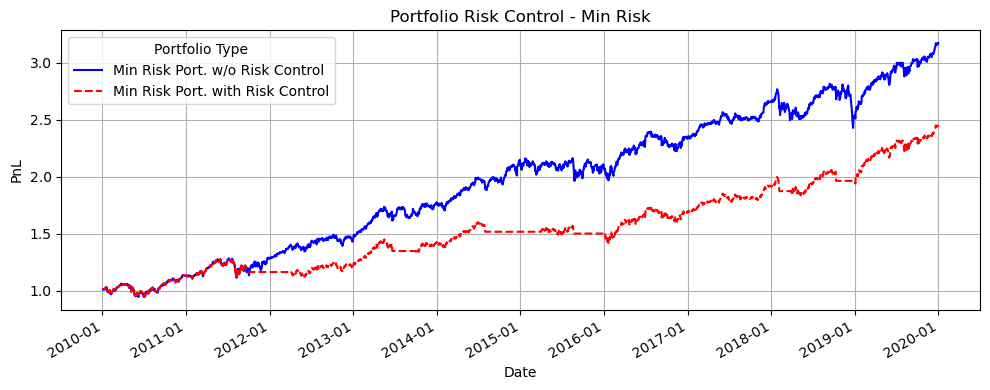

In [77]:
plot_min_risk_portfolios(rm_min)

In [78]:
rm_max =\
    risk_control(rm_target[2], rm_max_threshold, rebalance_test_tag, 2)

rm_max =\
    rm_max.rename(columns={'ret': 'old_ret', 
                           'PnL': 'old_PnL',
                           'pct_change': 'ret',
                           'PnL_rm': 'PnL'})
rm_max.tail()

2nd strike:  2010-01-22 00:00:00
risk control No. 1
from 2010-01-25 00:00:00 to 2010-10-01 00:00:00
2nd strike:  2011-09-22 00:00:00
risk control No. 2
from 2011-09-23 00:00:00 to 2012-04-01 00:00:00
2nd strike:  2011-10-03 00:00:00
risk control No. 3
from 2011-10-04 00:00:00 to 2012-04-01 00:00:00
2nd strike:  2011-11-01 00:00:00
risk control No. 4
from 2011-11-02 00:00:00 to 2012-04-01 00:00:00
2nd strike:  2013-06-20 00:00:00
risk control No. 5
from 2013-06-21 00:00:00 to 2013-10-01 00:00:00
2nd strike:  2015-08-21 00:00:00
risk control No. 6
from 2015-08-24 00:00:00 to 2016-01-01 00:00:00
2nd strike:  2015-09-01 00:00:00
risk control No. 7
from 2015-09-02 00:00:00 to 2016-01-01 00:00:00
2nd strike:  2015-09-28 00:00:00
risk control No. 8
from 2015-09-29 00:00:00 to 2016-01-01 00:00:00
2nd strike:  2018-02-05 00:00:00
risk control No. 9
from 2018-02-06 00:00:00 to 2018-04-01 00:00:00
2nd strike:  2018-03-23 00:00:00
risk control No. 10
from 2018-03-26 00:00:00 to 2018-04-01 00:00:00

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,old_ret,old_PnL,ret,PnL
2019-12-24,-0.0,0.0,-0.0,0.0,-0.000216,0.0,0.000314,0.0,0.000048,0.000048,0.000194,3.725551,0.000194,2.996845
2019-12-26,0.0,0.0,0.0,0.0,0.002412,0.0,0.002044,-0.0,0.000817,0.000239,0.005511,3.746084,0.005511,3.013362
2019-12-27,0.0,-0.0,0.0,-0.0,-0.000278,0.0,-0.000031,-0.0,0.000721,-0.000085,0.000326,3.747305,0.000326,3.014344
2019-12-30,-0.0,-0.0,-0.0,-0.0,-0.002195,-0.0,-0.00088,-0.0,-0.000144,-0.000234,-0.003454,3.734363,-0.003454,3.003934
2019-12-31,0.0,0.0,0.0,0.0,0.00102,0.0,0.000094,0.0,0.002787,0.000112,0.004013,3.749349,0.004013,3.015988


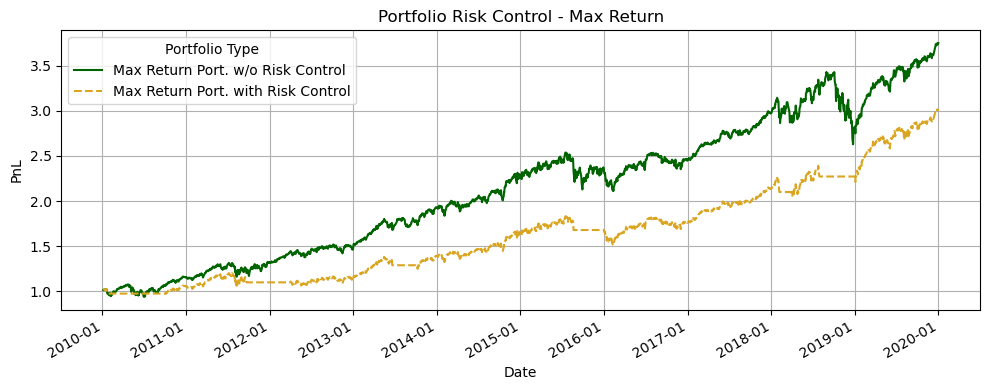

In [79]:
# plt.figure(figsize=[15,15])
# plt.plot(rm_max['old_PnL'], label = 'Max Return Port. w/o Risk Control')
# plt.plot(rm_max['PnL'], label = 'Max Return Port. with Risk Control')
# plt.title('Portfolio Risk Control - Max Return')
# plt.legend()
# plt.show()

plot_max_return_portfolios(rm_max)

In [80]:
# Consolidate In-Sample Performance Metrics
rm_w9m4_result =\
{
    'Roll w9m4 Min Risk Port.':
    [

        rm_min['PnL'][-1]**(252/len(rm_min))-1,
        rm_min['PnL'][-1]-1,

        rm_min['ret'].std()*252**0.5,
        VaR_para(rm_min, 0.01),
        VaR_hist(rm_min, 0.01),
        VaR_para(rm_min, 0.05),
        VaR_hist(rm_min, 0.05),
    ],
    'Roll w9m4 Max Return Port.':
    [

        rm_max['PnL'][-1]**(252/len(rm_max))-1,
        rm_max['PnL'][-1]-1,

        rm_max['ret'].std()*252**0.5,
        VaR_para(rm_max, 0.01),
        VaR_hist(rm_max, 0.01),
        VaR_para(rm_max, 0.05),
        VaR_hist(rm_max, 0.05),
    ],
}


# Define the risk-free rate
risk_free_rate = 0

# Calculate Sharpe Ratios for both portfolios
sharpe_ratio_min = (rm_min['PnL'][-1]**(252/len(rm_min))-1 - risk_free_rate) / (rm_min['ret'].std() * 252**0.5)
sharpe_ratio_max = (rm_max['PnL'][-1]**(252/len(rm_max))-1 - risk_free_rate) / (rm_max['ret'].std() * 252**0.5)

# Append Sharpe Ratios to the existing metrics dictionary
rm_w9m4_result['Roll w9m4 Min Risk Port.'].append(sharpe_ratio_min)
rm_w9m4_result['Roll w9m4 Max Return Port.'].append(sharpe_ratio_max)

# Convert dictionary into DataFrame
rm_w9m4_result = pd.DataFrame(rm_w9m4_result)

# Update DataFrame index to include Sharpe Ratio
rm_w9m4_result.index = [
    'Ann. Return', 
    'Total Return',
    'Ann. Vol',     
    'VaR 1d 1% - para',
    'VaR 1d 1% - hist',
    'VaR 1d 5% - para',
    'VaR 1d 5% - hist',
    'Sharpe Ratio'  # Add this line to include the Sharpe Ratio
]



rm_w9m4_result

,Roll w9m4 Min Risk Port.,Roll w9m4 Max Return Port.
Ann. Return,0.094011,0.116913
Total Return,1.452446,2.015988
Ann. Vol,0.099271,0.107986
VaR 1d 1% - para,0.014172,0.015363
VaR 1d 1% - hist,0.019241,0.020925
VaR 1d 5% - para,0.009910,0.010727
VaR 1d 5% - hist,0.009407,0.010664
Sharpe Ratio,0.947022,1.082668


In [81]:
rm_target[0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.122615,0.141529
Total Return,2.173295,2.749349
Ann. Vol,0.119176,0.142263
VaR 1d 1% - para,0.016977,0.020282
VaR 1d 1% - hist,0.020390,0.026229
VaR 1d 5% - para,0.011861,0.014175
VaR 1d 5% - hist,0.012039,0.014315
Sharpe Ratio,1.028858,0.994838


> ### <span style="color:red;">With proper risk control, the VaR is metrics are enhanced. Further more, the Sharpe for Max Return Portfolio also improved </span>

##### <a id = "p26"> </a> 2.6 Model Decision [back to table of contents](#top)

> <span style="color:red;">Conclusion:</span>
1. choice of less crowded rebalancing windows.
2. Min Risk portfolio tends to excel in shorter horizon.
3. Max Return portfolio tends to excel in longer horizon.
4. Diversity is needed, but not necessarily exhaustive.
5. Portfolio level Risk Management is preferred.
6. With properly tuned risk control, some shorting can be adopted.

In [82]:
# Assuming diverse_roll is correctly defined and the necessary libraries and functions are imported

Model_Decisions = []
model_labels = [
    "Model 1: Rebalance every 9 months, multiplier 5, Bounds(0,1)",
    "Model 2: Rebalance every 9 months, multiplier 5, Bounds(-0.5,1)",
    "Model 3: Rebalance every 11 months, multiplier 4, Bounds(0,1)",
    "Model 4: Rebalance every 11 months, multiplier 4, Bounds(-0.5,1)",
    "Model 5: Rebalance every 7 months, multiplier 2, Bounds(0,1)",
    "Model 6: Rebalance every 7 months, multiplier 2, Bounds(-0.5,1)"
]

# Populate Model_Decisions with diverse_roll results
Model_Decisions += [diverse_roll(Ind10, train_end, final_test, 9, 5, Bounds(0,1))]
Model_Decisions += [diverse_roll(Ind10, train_end, final_test, 9, 5, Bounds(-0.5,1))]
Model_Decisions += [diverse_roll(Ind10, train_end, final_test, 11, 4, Bounds(0,1))]
Model_Decisions += [diverse_roll(Ind10, train_end, final_test, 11, 4, Bounds(-0.5,1))]
Model_Decisions += [diverse_roll(Ind10, train_end, final_test, 7, 2, Bounds(0,1))]
Model_Decisions += [diverse_roll(Ind10, train_end, final_test, 7, 2, Bounds(-0.5,1))]

# Iterate over Model_Decisions and print details
for idx, model in enumerate(Model_Decisions):
    print(f"--- {model_labels[idx]} ---")
    print(model[0])  # Assuming model[0] is the DataFrame of results
    print()  # Print a newline for better separation


--- Model 1: Rebalance every 9 months, multiplier 5, Bounds(0,1) ---
                  Roll Min Risk Port.  Roll Max Return Port.
Ann. Return                  0.030386              -0.005758
Total Return                 0.132429              -0.023708
Ann. Vol                     0.202012               0.290177
VaR 1d 1% - para             0.029404               0.042380
VaR 1d 1% - hist             0.040413               0.053984
VaR 1d 5% - para             0.020732               0.029922
VaR 1d 5% - hist             0.017647               0.028871
Sharpe Ratio                 0.150415              -0.019844

--- Model 2: Rebalance every 9 months, multiplier 5, Bounds(-0.5,1) ---
                  Roll Min Risk Port.  Roll Max Return Port.
Ann. Return                 -0.040329              -0.212768
Total Return                -0.157202              -0.629890
Ann. Vol                     0.203791               0.401138
VaR 1d 1% - para             0.029945               0.059414
VaR 

> ### <span style="color:red;">Let's look at final model choice:</span> 
*  <span style="color:red;">rebalancing every 7 mths</span> 
* <span style="color:red;">prior twice lenth of history</span> 
* <span style="color:red;">No short selling</span> 
* <span style="color:red;">Max Return allocation logic</span> 

In [83]:
final_model = Model_Decisions[-2]

In [84]:
final_model_in_sample =\
    diverse_roll(Ind10, train_start, train_end, 7, 2, Bounds(0,1))

In [85]:
final_model_in_sample[0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.130070,0.139037
Total Return,2.390072,2.668421
Ann. Vol,0.117665,0.156294
VaR 1d 1% - para,0.016731,0.022339
VaR 1d 1% - hist,0.020651,0.029794
VaR 1d 5% - para,0.011679,0.015629
VaR 1d 5% - hist,0.011566,0.015875
Sharpe Ratio,1.105420,0.889586


In [86]:
final_model_min_threshold =\
    final_model_in_sample[0].loc['VaR 1d 1% - hist','Roll Min Risk Port.']
final_model_max_threshold =\
    final_model_in_sample[0].loc['VaR 1d 1% - hist','Roll Max Return Port.']
final_model_min_threshold, final_model_max_threshold

(0.020650965891015113, 0.029794098514323786)

In [87]:
final_test_tag, _ =\
    gen_date_tag(train_end, final_test, 7, 2)
final_test_tag

['20200101',
 '20200801',
 '20210301',
 '20211001',
 '20220501',
 '20221201',
 '20230701',
 '20240201',
 '20240301']

* Setting VaR violation threshold to 1 strike would filter out many market movements
* Setting VaR violation threshold to 3 strikes would filter few market movements, and experience large portfolio drawdowns (and happenly equivalent to no control in out-of-sample test window)

2nd strike:  2020-02-27 00:00:00
risk control No. 1
from 2020-02-28 00:00:00 to 2020-08-01 00:00:00
2nd strike:  2020-03-09 00:00:00
risk control No. 2
from 2020-03-10 00:00:00 to 2020-08-01 00:00:00
2nd strike:  2020-03-11 00:00:00
risk control No. 3
from 2020-03-12 00:00:00 to 2020-08-01 00:00:00
2nd strike:  2020-03-12 00:00:00
risk control No. 4
from 2020-03-13 00:00:00 to 2020-08-01 00:00:00
2nd strike:  2020-03-16 00:00:00
risk control No. 5
from 2020-03-17 00:00:00 to 2020-08-01 00:00:00
2nd strike:  2020-03-18 00:00:00
risk control No. 6
from 2020-03-19 00:00:00 to 2020-08-01 00:00:00
2nd strike:  2020-03-20 00:00:00
risk control No. 7
from 2020-03-23 00:00:00 to 2020-08-01 00:00:00
2nd strike:  2020-03-23 00:00:00
risk control No. 8
from 2020-03-24 00:00:00 to 2020-08-01 00:00:00
2nd strike:  2020-04-01 00:00:00
risk control No. 9
from 2020-04-02 00:00:00 to 2020-08-01 00:00:00
2nd strike:  2020-06-11 00:00:00
risk control No. 10
from 2020-06-12 00:00:00 to 2020-08-01 00:00:00

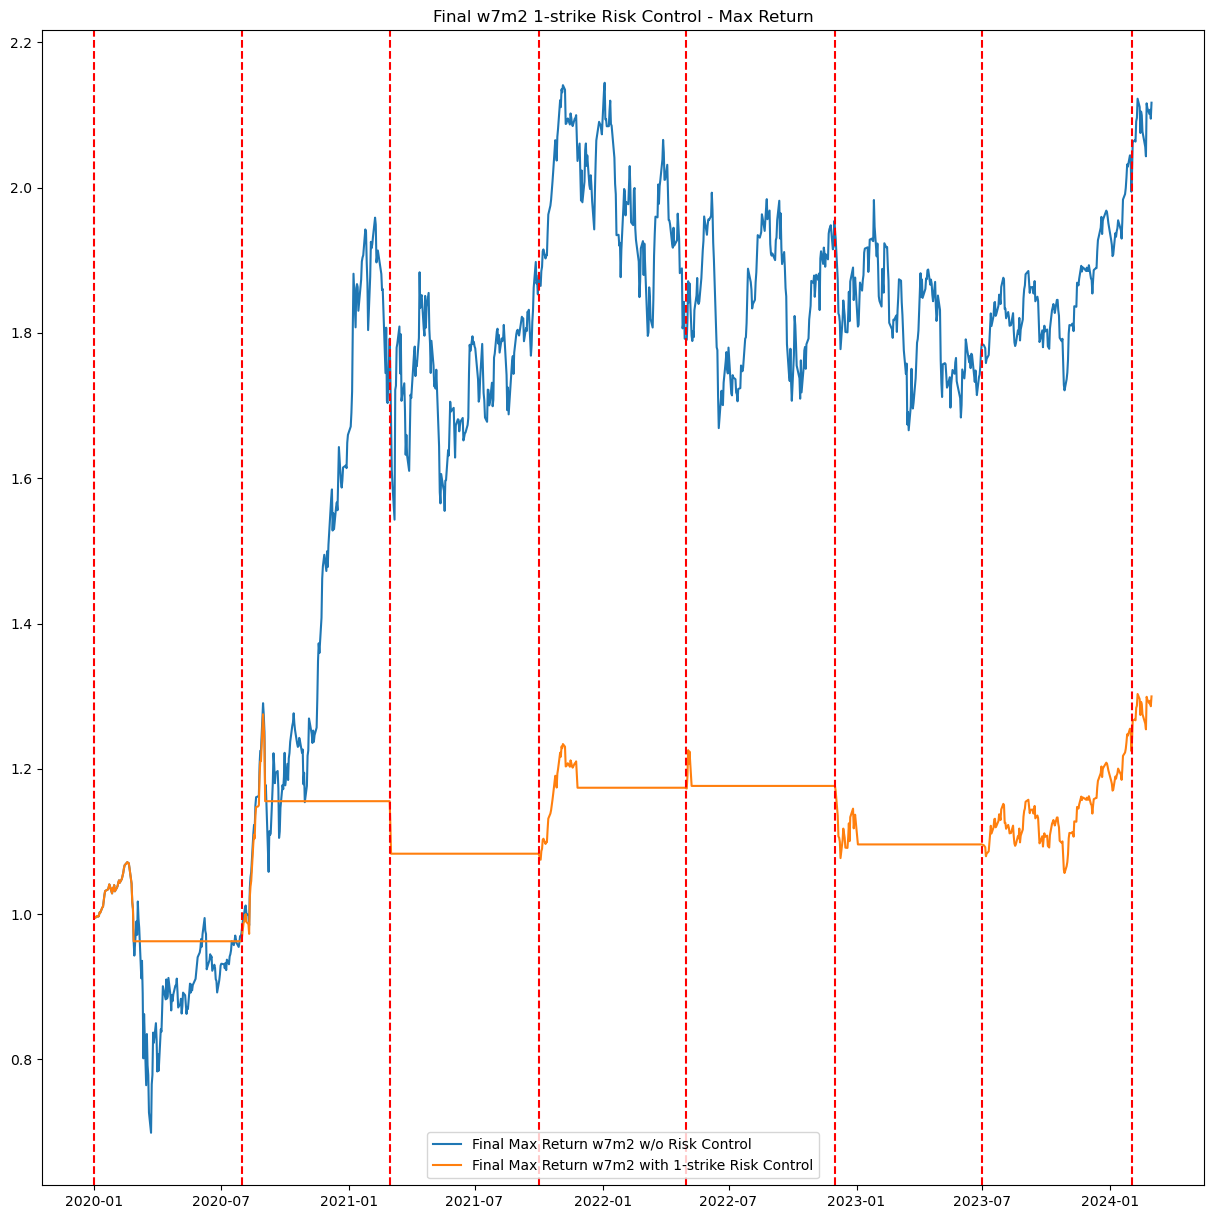

In [88]:
rm_w7m2_max =\
    risk_control(final_model[2], final_model_max_threshold, final_test_tag, 1)
rm_w7m2_max =\
    rm_w7m2_max.rename(
    columns={'ret': 'old_ret',
             'PnL': 'old_PnL',
             'pct_change': 'ret',
             'PnL_rm': 'PnL'}
    )
print(rm_w7m2_max.tail())
plt.figure(figsize=[15,15])
plt.plot(rm_w7m2_max['old_PnL'], label = 'Final Max Return w7m2 w/o Risk Control')
plt.plot(rm_w7m2_max['PnL'], label = 'Final Max Return w7m2 with 1-strike Risk Control')
plt.title('Final w7m2 1-strike Risk Control - Max Return')

for date in final_test_tag[:-1]:
    date = pd.to_datetime(date)
    plt.axvline(x=date, color='red', linestyle='--')
plt.legend()
plt.show()

           NoDur     Durbl Manuf Enrgy     HiTec Telcm     Shops     Hlth   \
2024-02-23   0.0      -0.0   0.0  -0.0 -0.002998   0.0  0.000002  0.000001   
2024-02-26  -0.0  0.000001  -0.0   0.0 -0.003997  -0.0  0.000001      -0.0   
2024-02-27  -0.0       0.0   0.0  -0.0  0.002798   0.0  0.000001       0.0   
2024-02-28  -0.0       0.0   0.0  -0.0 -0.005795   0.0       0.0 -0.000001   
2024-02-29   0.0       0.0   0.0   0.0  0.010491   0.0  0.000002 -0.000001   

               Utils Other   old_ret   old_PnL       ret       PnL  
2024-02-23       0.0   0.0 -0.002995  2.109702 -0.002995  2.109702  
2024-02-26 -0.000001  -0.0 -0.003997  2.101269 -0.003997  2.101269  
2024-02-27  0.000001   0.0  0.002800  2.107153  0.002800  2.107153  
2024-02-28       0.0  -0.0 -0.005795  2.094941 -0.005795  2.094941  
2024-02-29       0.0   0.0  0.010494  2.116925  0.010494  2.116925  


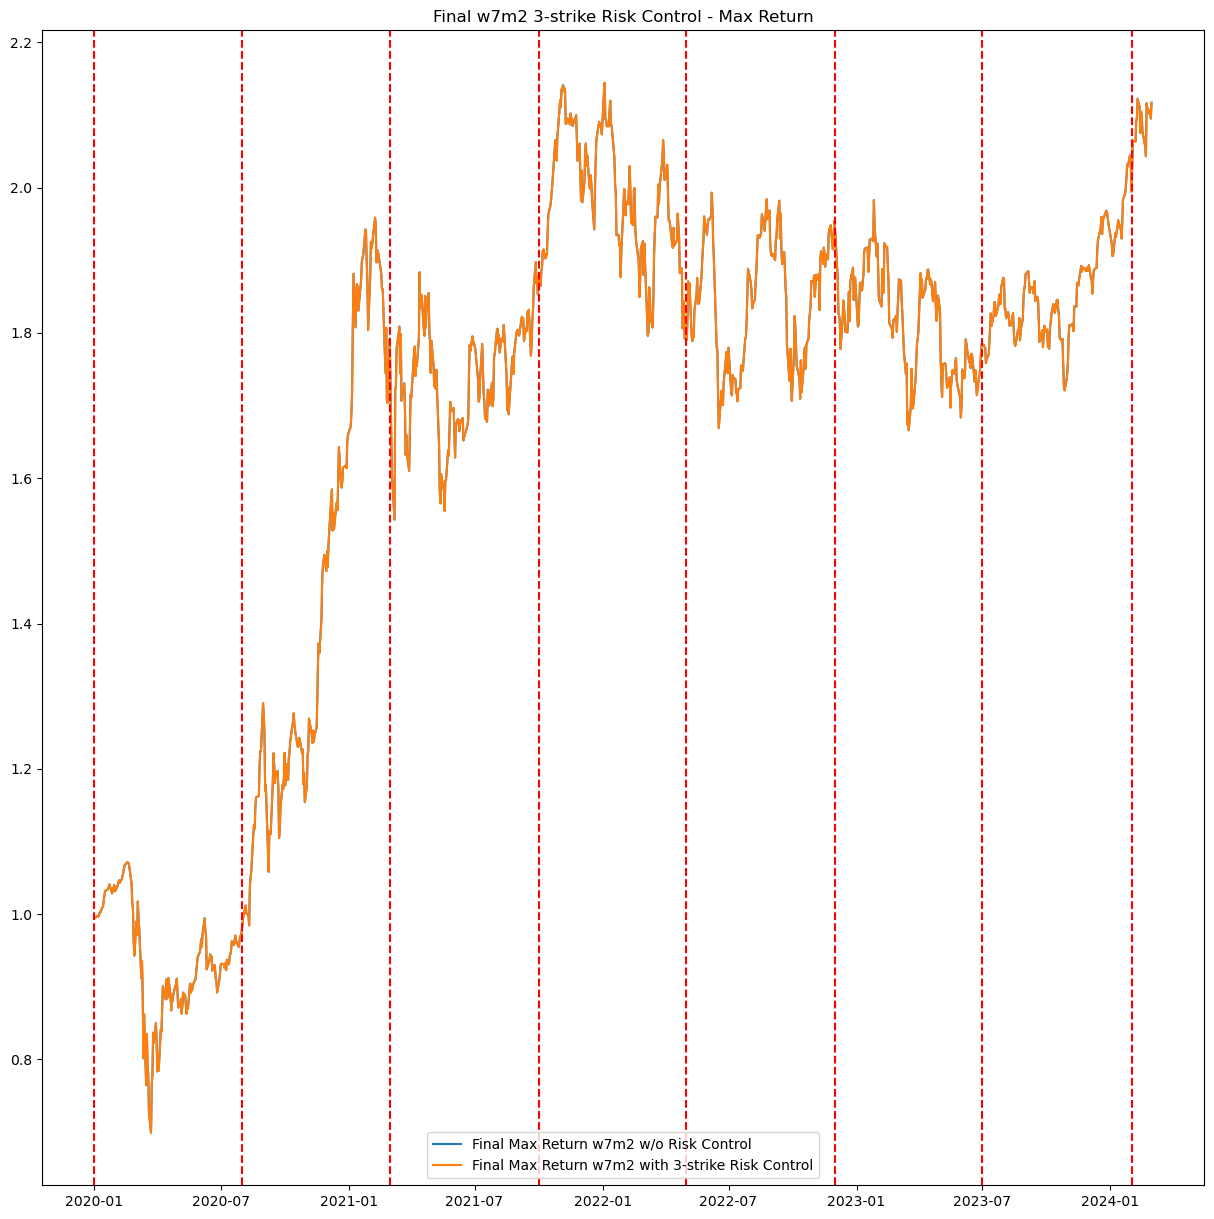

In [89]:
rm_w7m2_max =\
    risk_control(final_model[2], final_model_max_threshold, final_test_tag, 3)
rm_w7m2_max =\
    rm_w7m2_max.rename(
    columns={'ret': 'old_ret',
             'PnL': 'old_PnL',
             'pct_change': 'ret',
             'PnL_rm': 'PnL'}
    )
print(rm_w7m2_max.tail())
plt.figure(figsize=[15,15])
plt.plot(rm_w7m2_max['old_PnL'], label = 'Final Max Return w7m2 w/o Risk Control')
plt.plot(rm_w7m2_max['PnL'], label = 'Final Max Return w7m2 with 3-strike Risk Control')
plt.title('Final w7m2 3-strike Risk Control - Max Return')

for date in final_test_tag[:-1]:
    date = pd.to_datetime(date)
    plt.axvline(x=date, color='red', linestyle='--')
plt.legend()
plt.show()

<span style="color:red;">* Setting VaR violation threshold to 2 strikes would be proper and reasonable</span>

In [90]:
rm_w7m2_max =\
    risk_control(final_model[2], final_model_max_threshold, final_test_tag, 2)
rm_w7m2_max =\
    rm_w7m2_max.rename(
    columns={'ret': 'old_ret',
             'PnL': 'old_PnL',
             'pct_change': 'ret',
             'PnL_rm': 'PnL'}
    )
rm_w7m2_max.tail()


2nd strike:  2020-03-12 00:00:00
risk control No. 1
from 2020-03-13 00:00:00 to 2020-08-01 00:00:00
2nd strike:  2020-03-23 00:00:00
risk control No. 2
from 2020-03-24 00:00:00 to 2020-08-01 00:00:00
2nd strike:  2021-03-04 00:00:00
risk control No. 3
from 2021-03-05 00:00:00 to 2021-10-01 00:00:00


,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,old_ret,old_PnL,ret,PnL
2024-02-23,0.0,-0.0,0.0,-0.0,-0.002998,0.0,0.000002,0.000001,0.0,0.0,-0.002995,2.109702,-0.002995,1.488720
2024-02-26,-0.0,0.000001,-0.0,0.0,-0.003997,-0.0,0.000001,-0.0,-0.000001,-0.0,-0.003997,2.101269,-0.003997,1.482770
2024-02-27,-0.0,0.0,0.0,-0.0,0.002798,0.0,0.000001,0.0,0.000001,0.0,0.002800,2.107153,0.002800,1.486921
2024-02-28,-0.0,0.0,0.0,-0.0,-0.005795,0.0,0.0,-0.000001,0.0,-0.0,-0.005795,2.094941,-0.005795,1.478304
2024-02-29,0.0,0.0,0.0,0.0,0.010491,0.0,0.000002,-0.000001,0.0,0.0,0.010494,2.116925,0.010494,1.493817


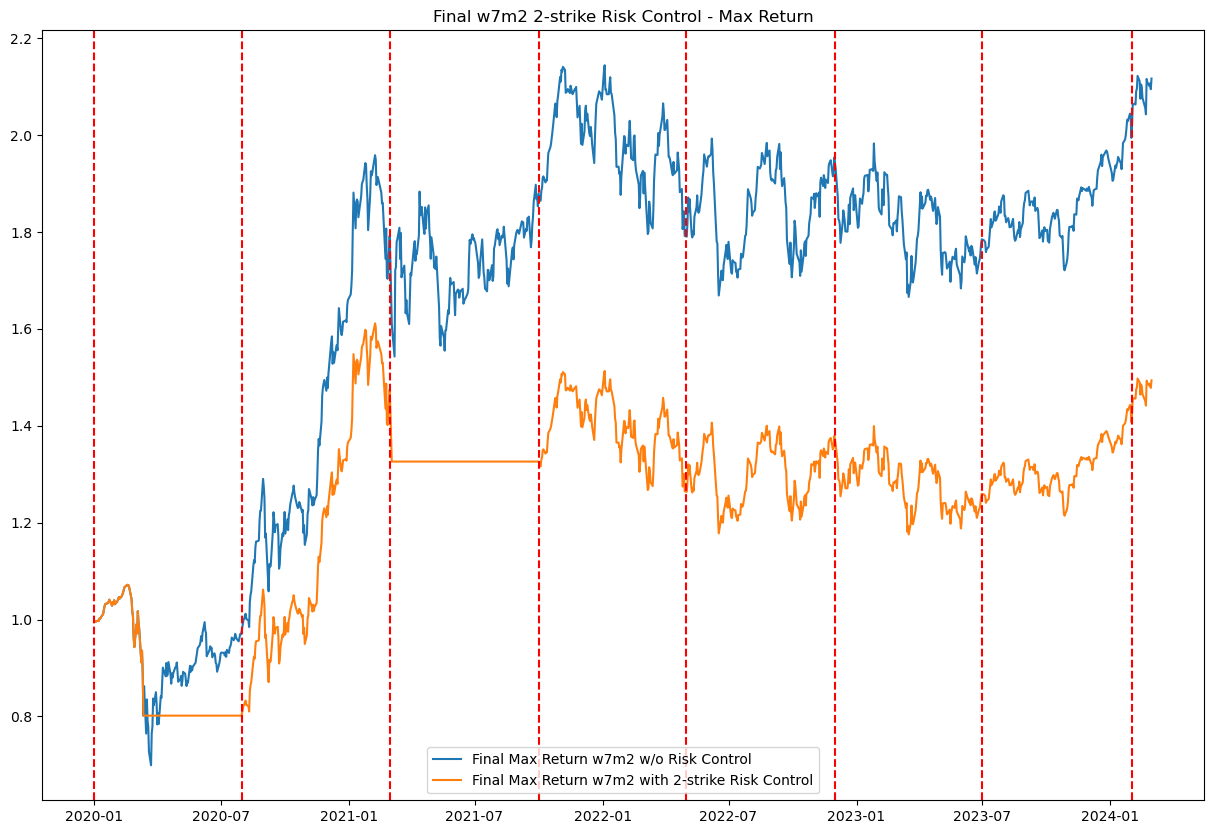

In [91]:
plt.figure(figsize=[15,10])
plt.plot(rm_w7m2_max['old_PnL'], label = 'Final Max Return w7m2 w/o Risk Control')
plt.plot(rm_w7m2_max['PnL'], label = 'Final Max Return w7m2 with 2-strike Risk Control')
plt.title('Final w7m2 2-strike Risk Control - Max Return')

for date in final_test_tag[:-1]:
    date = pd.to_datetime(date)
    plt.axvline(x=date, color='red', linestyle='--')
plt.legend()
plt.show()

In [92]:
# Consolidate Out-of-Sample Performance Metrics
final_w7m2_result =\
{

    'final w7m2 Max Return Port.':
    [

        rm_w7m2_max['PnL'][-1]**(252/len(rm_max))-1,
        rm_w7m2_max['PnL'][-1]-1,

        rm_w7m2_max['ret'].std()*252**0.5,
        VaR_para(rm_w7m2_max, 0.01),
        VaR_hist(rm_w7m2_max, 0.01),
        VaR_para(rm_w7m2_max, 0.05),
        VaR_hist(rm_w7m2_max, 0.05),
    ],
}

# Define the risk-free rate
risk_free_rate = 0

# Calculate the Sharpe Ratio for the portfolio
sharpe_ratio_max = (rm_w7m2_max['PnL'][-1]**(252/len(rm_w7m2_max))-1 - risk_free_rate) / (rm_w7m2_max['ret'].std() * 252**0.5)

# Append the Sharpe Ratio to the existing metrics dictionary
final_w7m2_result['final w7m2 Max Return Port.'].append(sharpe_ratio_max)

# Convert dictionary into DataFrame
final_w7m2_result = pd.DataFrame(final_w7m2_result)

# Update DataFrame index to include Sharpe Ratio
final_w7m2_result.index = [
    'Ann. Return', 
    'Total Return',
    'Ann. Vol',     
    'VaR 1d 1% - para',
    'VaR 1d 1% - hist',
    'VaR 1d 5% - para',
    'VaR 1d 5% - hist',
    'Sharpe Ratio'  # Add this line to include the Sharpe Ratio
]


final_w7m2_result

,final w7m2 Max Return Port.
Ann. Return,0.041016
Total Return,0.493817
Ann. Vol,0.239656
VaR 1d 1% - para,0.034623
VaR 1d 1% - hist,0.045957
VaR 1d 5% - para,0.024334
VaR 1d 5% - hist,0.023626
Sharpe Ratio,0.423172


In [93]:
# below is before risk control for comparison
final_model = Model_Decisions[-2]
final_model[0][['Roll Max Return Port.']]

,Roll Max Return Port.
Ann. Return,0.197825
Total Return,1.116925
Ann. Vol,0.303913
VaR 1d 1% - para,0.043637
VaR 1d 1% - hist,0.051281
VaR 1d 5% - para,0.030590
VaR 1d 5% - hist,0.027417
Sharpe Ratio,0.650926
